# Notebook 09: Labor Force Participation and Working Hours

The previous notebooks examined income inequality (NB01-06), its relationship
to well-being (NB07), and whether economic growth translates to happiness over
time (NB08). This notebook turns to the labor market: **how much do people
actually work, and what does it buy them?**

The data reveal a striking pattern among rich countries: Americans work
substantially more hours per year than Europeans — roughly 200-400 more
hours annually, equivalent to 5-10 extra 40-hour workweeks. Yet countries
with shorter working hours often achieve comparable or higher productivity
per hour. This raises fundamental questions about the relationship between
work, output, and well-being.

### Key questions

1. How do working hours compare across countries today?
2. How have working hours changed over 150 years of industrialization?
3. How does labor force participation vary — especially the gender gap?
4. Is there a relationship between working hours and productivity?
5. Do people in countries with longer working hours report higher well-being?
6. Is there a relationship between inequality and working hours?

### Key literature

- **Alesina, Glaeser & Sacerdote (2005)**: "Work and Leisure in the US and
  Europe: Why So Different?" Labor market regulation and unionization explain
  much of the US-Europe gap.
- **Prescott (2004)**: Tax rates on labor income explain cross-country
  differences in hours worked.
- **Huberman & Minns (2007)**: Historical working hours data from 1870 onward,
  documenting the great decline in hours.
- **Pencavel (2015)**: The relationship between hours and output is nonlinear —
  beyond a threshold, more hours produce diminishing or even negative returns.

### Data sources

| Source | Coverage | Period |
|--------|----------|--------|
| Our World in Data / PWT | Working hours per worker, 185 countries | 1950-2023 |
| Huberman & Minns (via OWID) | Historical working hours, ~15 countries | 1870-1938 |
| World Bank (ILO estimates) | Labor force participation, all countries | 1990-2024 |

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from data.config import (
    FOCUS_COUNTRIES, WELLBEING_COUNTRIES, COUNTRY_NAMES, COUNTRY_COLORS,
    ISO2_TO_ISO3,
)
from data.plotting import (
    set_style, country_color, country_name, save_figure, annotate_countries,
)
from data import health_social, labor

set_style()

# Income tier classification (consistent with NB07/08)
INCOME_TIERS = {
    'High income': ['US', 'GB', 'FR', 'DE', 'SE', 'DK', 'NO', 'JP', 'AU', 'CL'],
    'Upper-middle': ['CN', 'BR', 'MX', 'ZA', 'TR', 'RU'],
    'Lower-middle': ['IN', 'ID', 'PH', 'EG', 'NG'],
    'Low income': ['ET', 'BD'],
}
TIER_COLORS = {
    'High income': '#4878a8',
    'Upper-middle': '#4a9a73',
    'Lower-middle': '#c06820',
    'Low income': '#b5403a',
}
COUNTRY_TIER = {}
for tier, codes in INCOME_TIERS.items():
    for c in codes:
        COUNTRY_TIER[c] = tier

def tier_color(code):
    return TIER_COLORS.get(COUNTRY_TIER.get(code, ''), '#999999')

***
## 1. Working Hours Across Countries Today

How many hours per year does the typical worker put in? The variation is
enormous. In some countries, workers average over 2,000 hours per year;
in others, under 1,400. The US consistently ranks among the longest-working
rich countries.

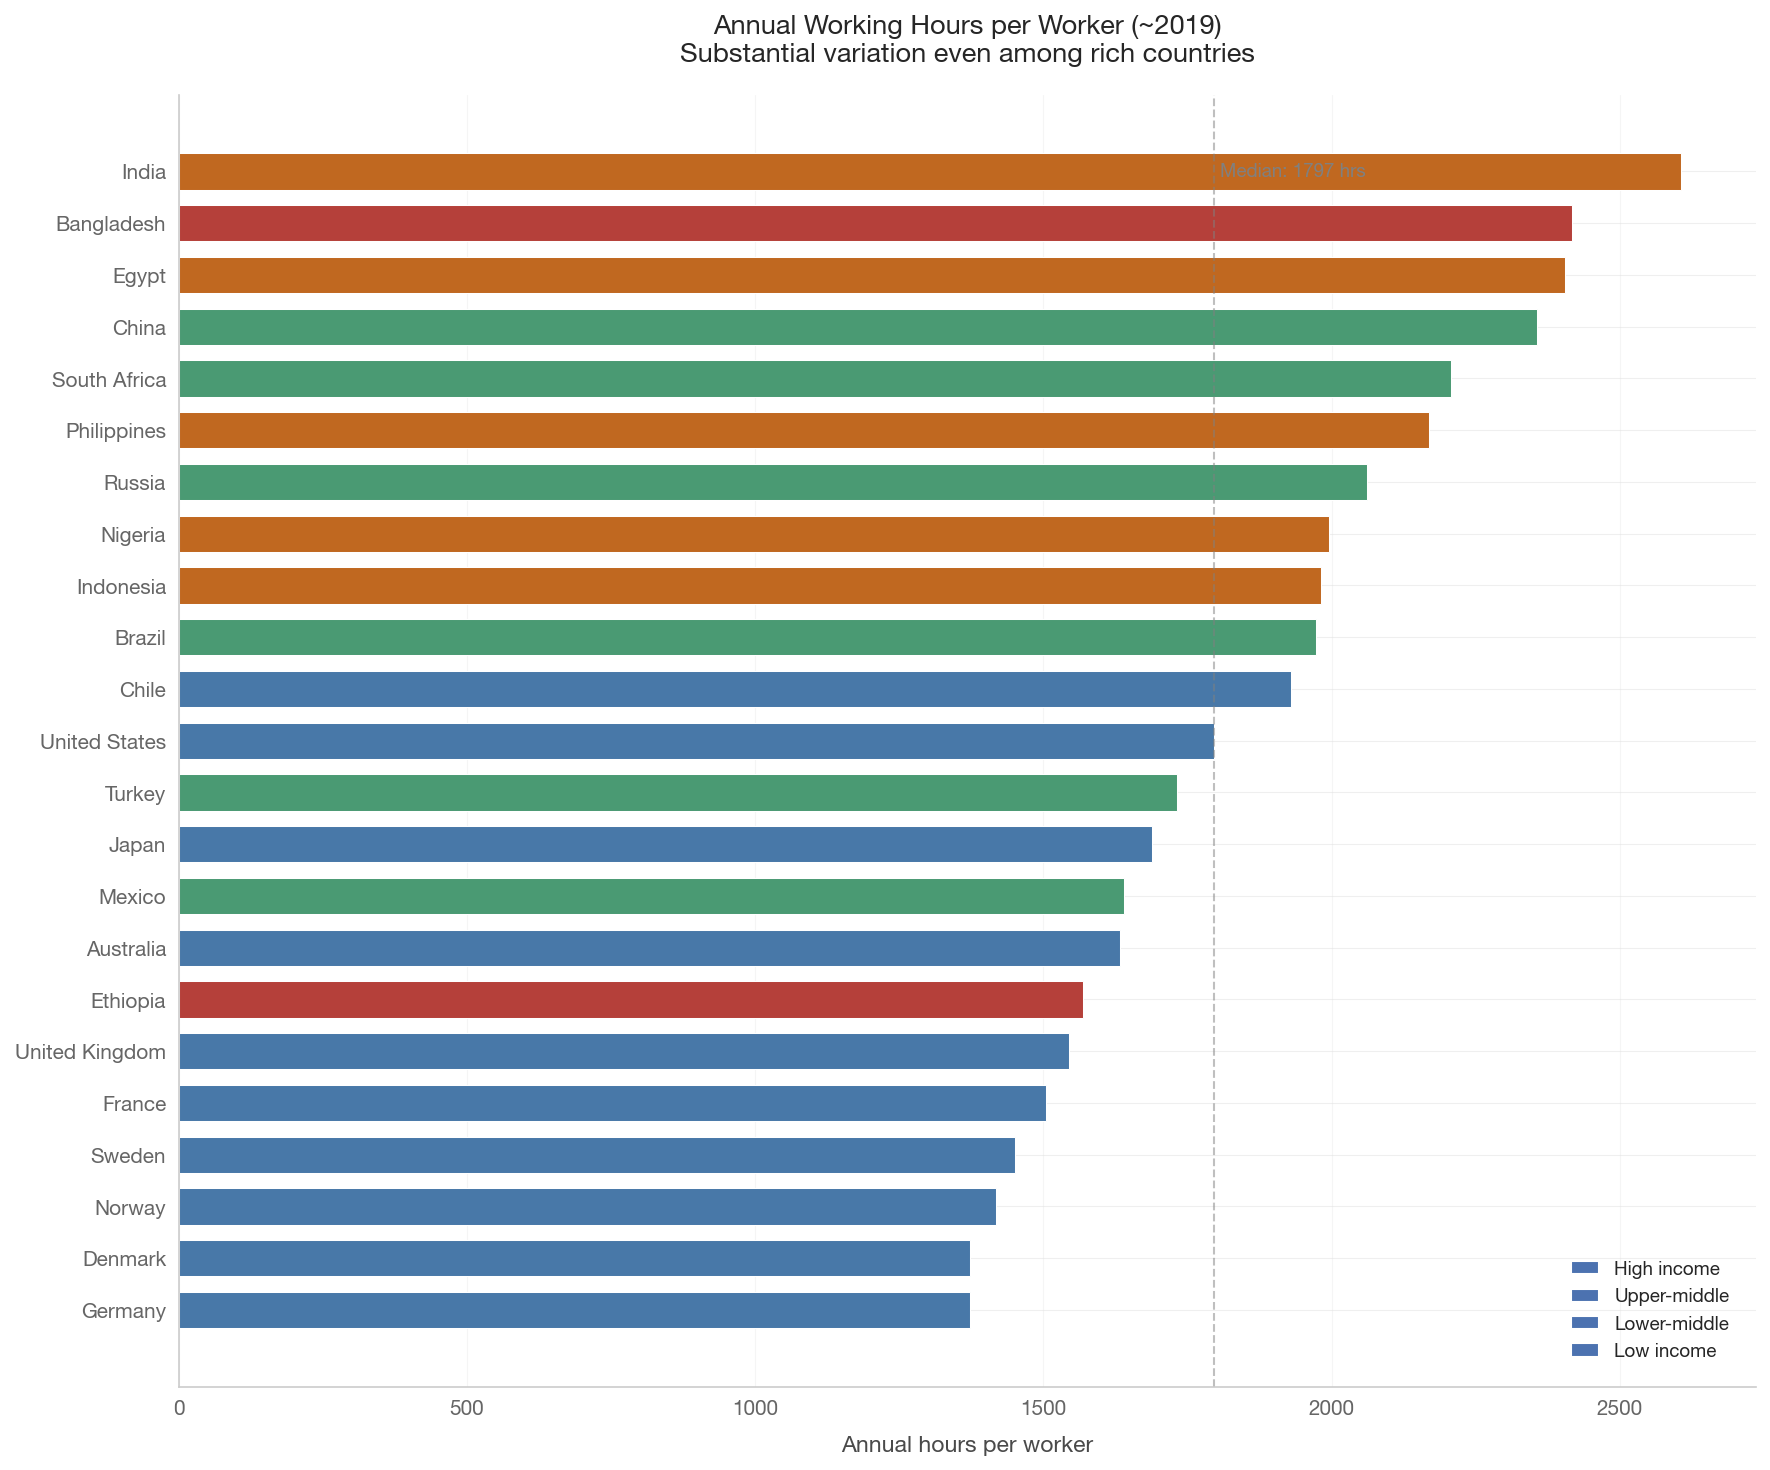

US: 1797 hours/year
Germany: 1372 hours/year
Gap: 425 hours = ~11 extra 40-hour workweeks
Denmark: 1372 hours/year
US-Denmark gap: 424 hours = ~11 extra workweeks

Range: 1372 to 2605 hours/year


In [2]:
# Load working hours snapshot (~2019)
hours_snap = labor.get_working_hours_snapshot(
    countries=WELLBEING_COUNTRIES, year=2019)

if not hours_snap.empty:
    # Sort by hours descending
    hours_snap = hours_snap.sort_values('hours_per_worker', ascending=True)
    hours_snap['country'] = hours_snap['country_code'].map(
        lambda c: country_name(c))
    colors = [tier_color(c) for c in hours_snap['country_code']]

    fig, ax = plt.subplots(figsize=(12, 10))
    bars = ax.barh(range(len(hours_snap)), hours_snap['hours_per_worker'],
                   color=colors, edgecolor='white', linewidth=0.5, height=0.7)
    ax.set_yticks(range(len(hours_snap)))
    ax.set_yticklabels(hours_snap['country'])
    ax.set_xlabel('Annual hours per worker')
    ax.set_title('Annual Working Hours per Worker (~2019)\n'
                 'Substantial variation even among rich countries',
                 fontsize=13)

    # Median reference line
    median_hrs = hours_snap['hours_per_worker'].median()
    ax.axvline(median_hrs, color='gray', linestyle='--', alpha=0.5,
               linewidth=1)
    ax.text(median_hrs + 10, len(hours_snap) - 1,
            f'Median: {median_hrs:.0f} hrs',
            va='center', fontsize=9, color='gray')

    for tier, color in TIER_COLORS.items():
        ax.barh([], [], color=color, label=tier)
    ax.legend(loc='lower right', fontsize=9)

    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    save_figure(fig, '09_working_hours_bar_chart')
    plt.show()

    # Key statistics
    us_hrs = hours_snap[hours_snap['country_code'] == 'US']['hours_per_worker'].values
    de_hrs = hours_snap[hours_snap['country_code'] == 'DE']['hours_per_worker'].values
    dk_hrs = hours_snap[hours_snap['country_code'] == 'DK']['hours_per_worker'].values

    if len(us_hrs) > 0 and len(de_hrs) > 0:
        gap = us_hrs[0] - de_hrs[0]
        print(f'US: {us_hrs[0]:.0f} hours/year')
        print(f'Germany: {de_hrs[0]:.0f} hours/year')
        print(f'Gap: {gap:.0f} hours = ~{gap/40:.0f} extra 40-hour workweeks')
    if len(dk_hrs) > 0 and len(us_hrs) > 0:
        gap_dk = us_hrs[0] - dk_hrs[0]
        print(f'Denmark: {dk_hrs[0]:.0f} hours/year')
        print(f'US-Denmark gap: {gap_dk:.0f} hours = ~{gap_dk/40:.0f} extra workweeks')
    print(f'\nRange: {hours_snap["hours_per_worker"].min():.0f} to '
          f'{hours_snap["hours_per_worker"].max():.0f} hours/year')
else:
    print('Working hours data not available.')

Correlation (log GDP vs hours): r = -0.622, p = 0.0015


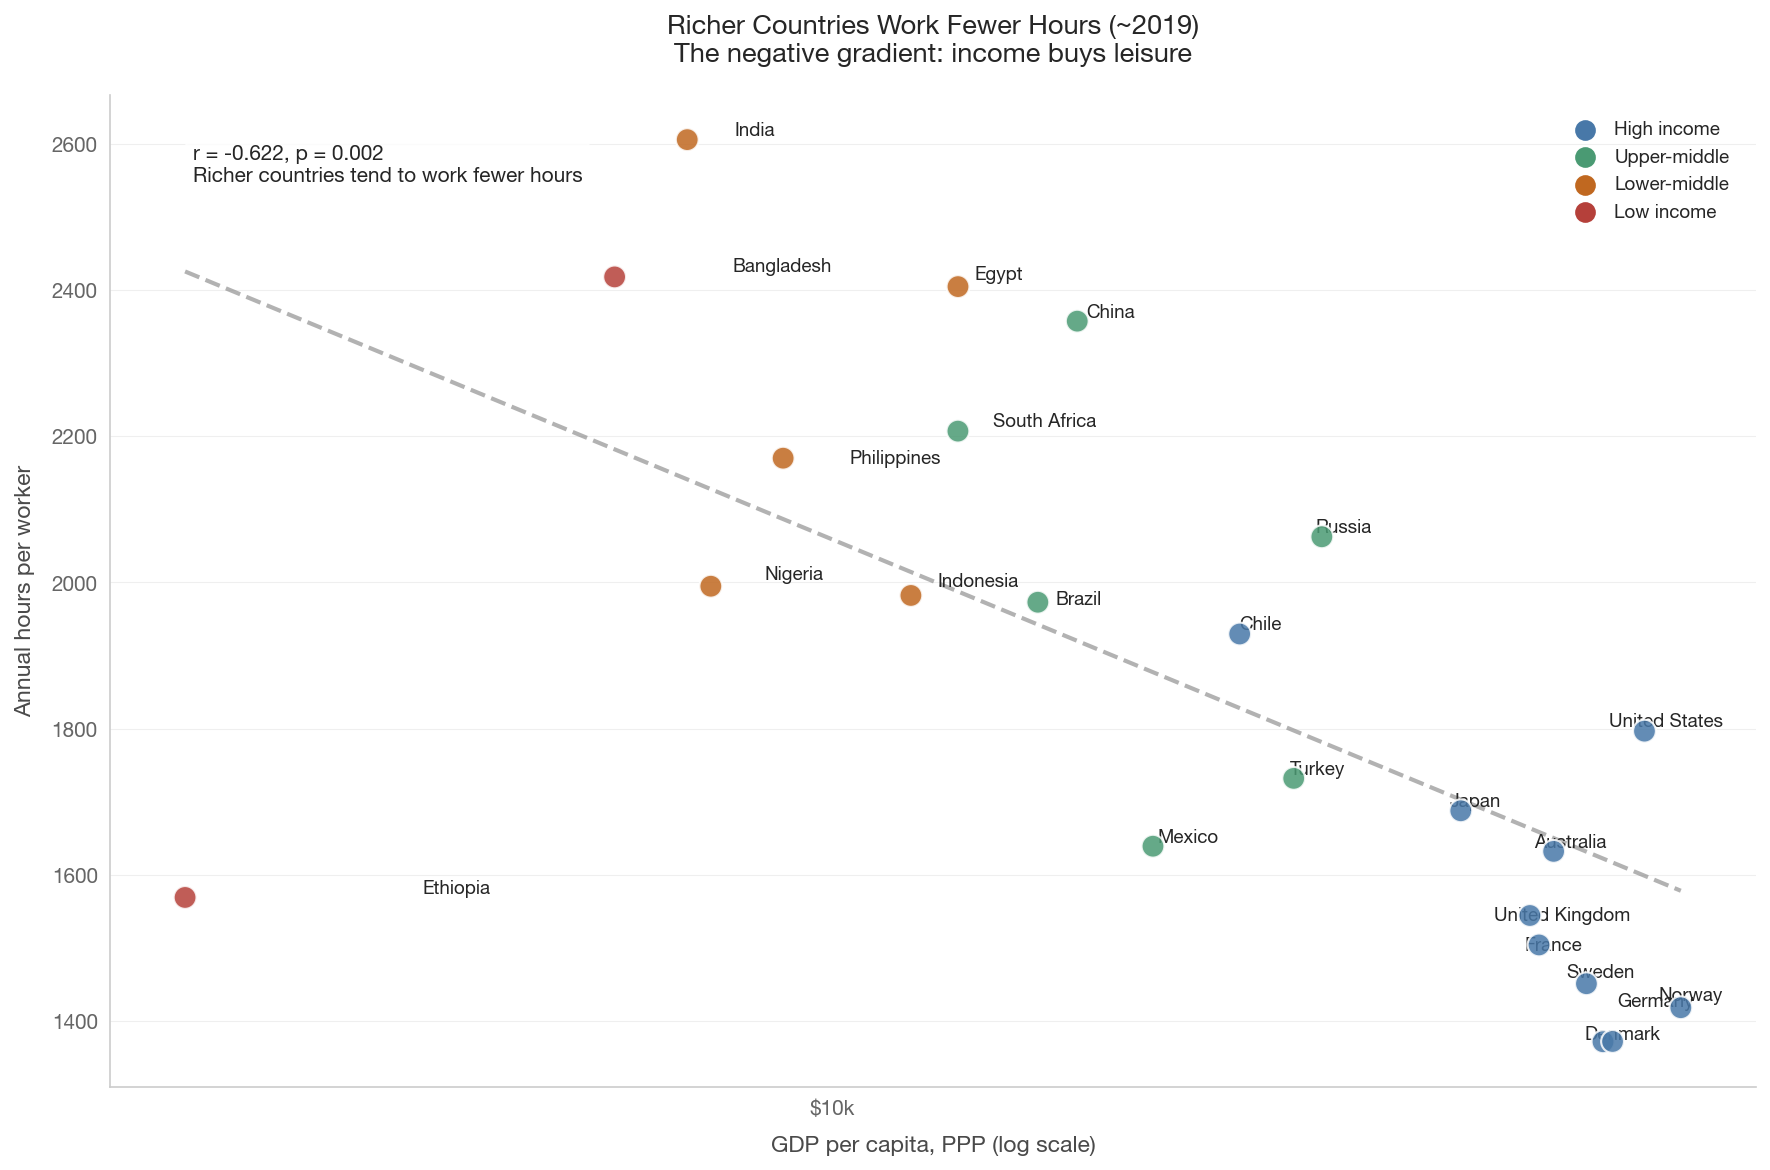

In [3]:
if not hours_snap.empty:
    # Load GDP data
    wb_data = health_social.get_wellbeing_data(year=2019)

    if not wb_data.empty:
        merged = hours_snap.merge(
            wb_data[['country_code', 'gdp_per_capita_ppp']],
            on='country_code', how='inner')
        merged = merged.dropna(subset=['gdp_per_capita_ppp',
                                        'hours_per_worker'])

        fig, ax = plt.subplots(figsize=(12, 8))
        colors = [tier_color(c) for c in merged['country_code']]
        ax.scatter(merged['gdp_per_capita_ppp'], merged['hours_per_worker'],
                   c=colors, s=120, zorder=5, edgecolors='white',
                   linewidth=1, alpha=0.85)

        # Log fit
        x = np.log(merged['gdp_per_capita_ppp'].values)
        y = merged['hours_per_worker'].values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() > 3:
            slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
            x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
            ax.plot(np.exp(x_fit), intercept + slope * x_fit,
                    color='gray', linestyle='--', linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95,
                    f'r = {r:.3f}, p = {p:.3f}\n'
                    f'Richer countries tend to work fewer hours',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8))
            print(f'Correlation (log GDP vs hours): r = {r:.3f}, p = {p:.4f}')

        annotate_countries(ax, merged['gdp_per_capita_ppp'].values,
                           merged['hours_per_worker'].values,
                           merged['country_code'].values)

        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(
            lambda x, _: f'${x/1000:.0f}k'))
        ax.set_xlabel('GDP per capita, PPP (log scale)')
        ax.set_ylabel('Annual hours per worker')
        ax.set_title('Richer Countries Work Fewer Hours (~2019)\n'
                     'The negative gradient: income buys leisure',
                     fontsize=13)

        for tier, color in TIER_COLORS.items():
            ax.scatter([], [], c=color, s=80, label=tier)
        ax.legend(loc='upper right', fontsize=9)

        plt.tight_layout()
        save_figure(fig, '09_working_hours_vs_gdp')
        plt.show()

***
## 2. The Long Decline: Working Hours Over 150 Years

One of the great achievements of economic development is the dramatic
reduction in working hours. In 1870, workers in industrialized countries
averaged 2,500-3,000+ hours per year — roughly 60-70 hours per week,
50 weeks per year. Today, the range is 1,300-1,800 in most rich countries.

This section uses historical data from Huberman & Minns (2007), extended
forward with Penn World Table data, both sourced via Our World in Data.

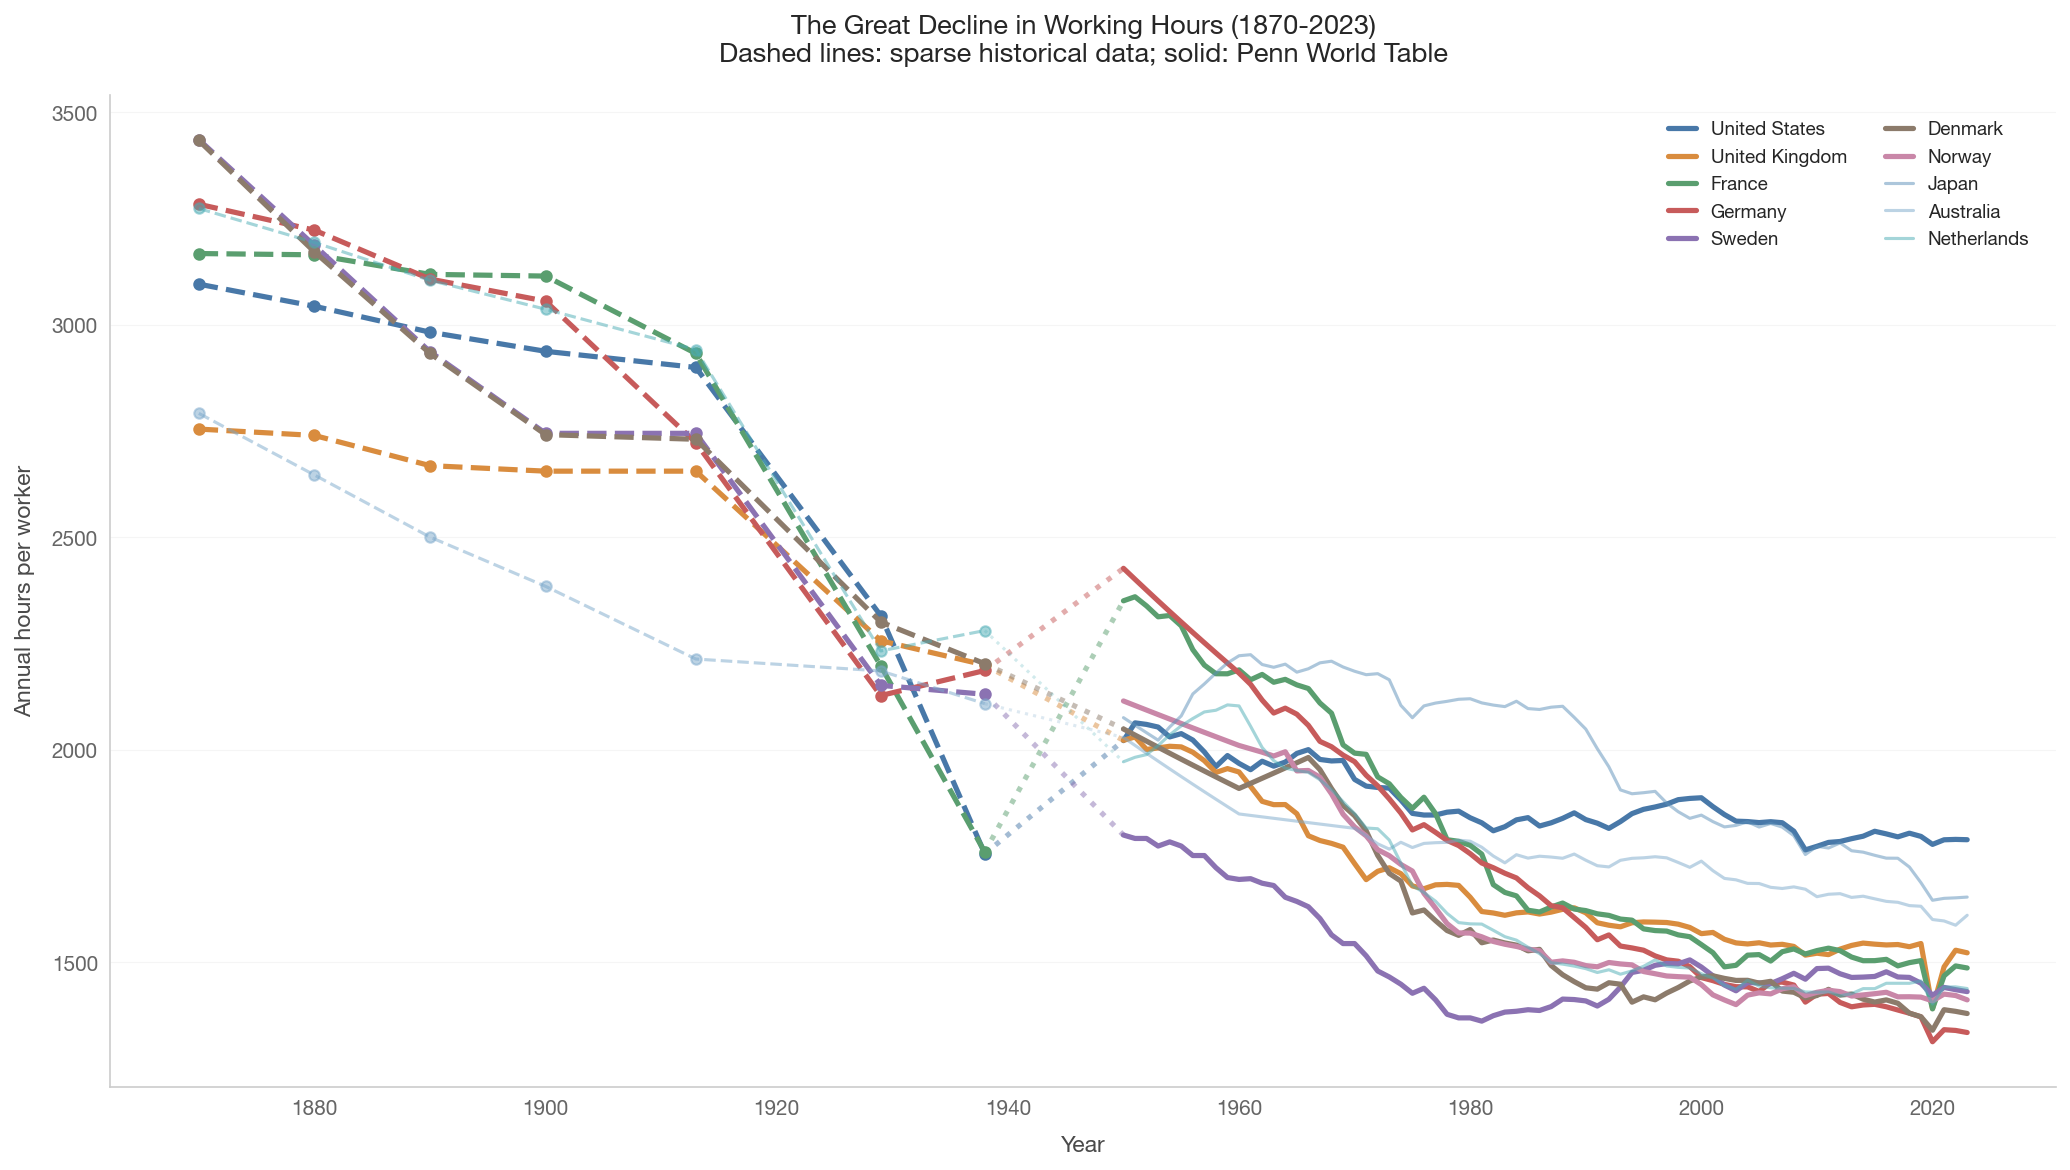

Decline in annual hours (countries with 1870 data):
  United States: 3096 -> 1789 (-42%)
  United Kingdom: 2755 -> 1523 (-45%)
  France: 3168 -> 1487 (-53%)
  Germany: 3284 -> 1335 (-59%)
  Sweden: 3436 -> 1432 (-58%)
  Denmark: 3434 -> 1380 (-60%)
  Australia: 2792 -> 1611 (-42%)
  Netherlands: 3274 -> 1439 (-56%)


In [4]:
# Load full historical time series
historical_countries = list(dict.fromkeys(
    FOCUS_COUNTRIES + ['JP', 'AU', 'NL']))

hours_hist = labor.get_working_hours_historical(
    countries=historical_countries, start_year=1870, end_year=2023)

if not hours_hist.empty:
    fig, ax = plt.subplots(figsize=(14, 8))

    for cc in historical_countries:
        cdf = hours_hist[hours_hist['country_code'] == cc].sort_values('year')
        if cdf.empty:
            continue

        # Split into pre-1950 (sparse) and post-1950 (continuous)
        pre = cdf[cdf['year'] < 1950]
        post = cdf[cdf['year'] >= 1950]

        color = country_color(cc)
        lw = 2.5 if cc in FOCUS_COUNTRIES else 1.5
        alpha = 1.0 if cc in FOCUS_COUNTRIES else 0.5

        # Pre-1950: markers with dashed line
        if not pre.empty:
            ax.plot(pre['year'], pre['hours_per_worker'],
                    color=color, linewidth=lw, linestyle='--',
                    marker='o', markersize=5, alpha=alpha)

        # Post-1950: solid line
        if not post.empty:
            ax.plot(post['year'], post['hours_per_worker'],
                    color=color, linewidth=lw, alpha=alpha,
                    label=country_name(cc))

        # Connect pre and post
        if not pre.empty and not post.empty:
            bridge = pd.concat([pre.iloc[[-1]], post.iloc[[0]]])
            ax.plot(bridge['year'], bridge['hours_per_worker'],
                    color=color, linewidth=lw, linestyle=':', alpha=alpha*0.5)

    ax.set_xlabel('Year')
    ax.set_ylabel('Annual hours per worker')
    ax.set_title('The Great Decline in Working Hours (1870-2023)\n'
                 'Dashed lines: sparse historical data; solid: Penn World Table',
                 fontsize=13)
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '09_working_hours_historical')
    plt.show()

    # Report percentage decline for countries with 1870 data
    print('Decline in annual hours (countries with 1870 data):')
    for cc in historical_countries:
        cdf = hours_hist[hours_hist['country_code'] == cc].sort_values('year')
        early = cdf[cdf['year'] <= 1880]
        late = cdf[cdf['year'] >= 2018]
        if not early.empty and not late.empty:
            h1 = early.iloc[0]['hours_per_worker']
            h2 = late.iloc[-1]['hours_per_worker']
            pct = (h2 - h1) / h1 * 100
            print(f'  {country_name(cc)}: {h1:.0f} -> {h2:.0f} '
                  f'({pct:+.0f}%)')
else:
    print('Historical working hours data not available.')

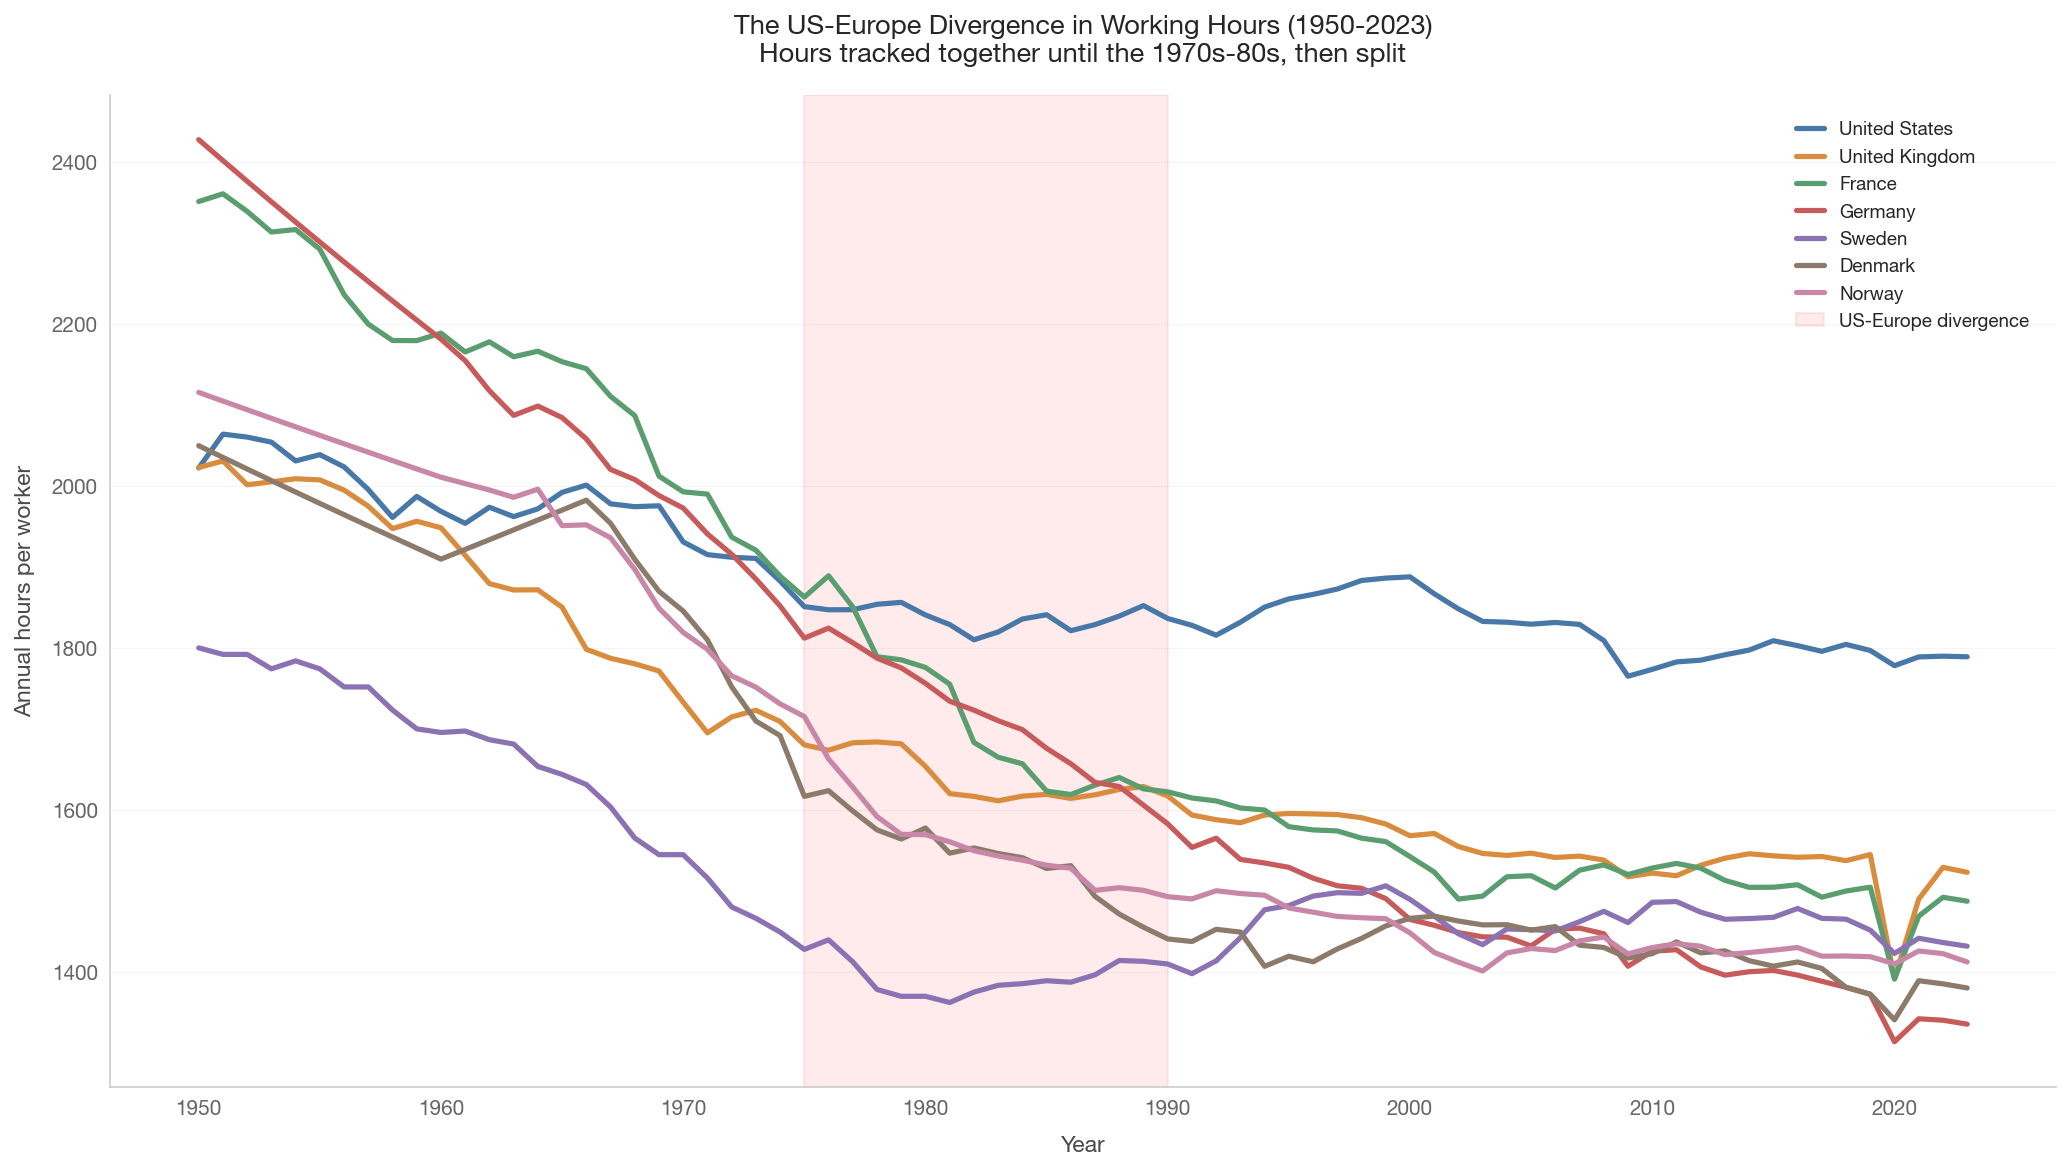


Working hours: ~1979 vs most recent
  United States: 1854 -> 1789 (-65 hours)
  United Kingdom: 1684 -> 1523 (-161 hours)
  France: 1789 -> 1487 (-302 hours)
  Germany: 1787 -> 1335 (-452 hours)
  Sweden: 1378 -> 1432 (+53 hours)
  Denmark: 1575 -> 1380 (-195 hours)
  Norway: 1592 -> 1412 (-179 hours)


In [5]:
if not hours_hist.empty:
    fig, ax = plt.subplots(figsize=(14, 8))

    post1950 = hours_hist[hours_hist['year'] >= 1950]

    for cc in FOCUS_COUNTRIES:
        cdf = post1950[post1950['country_code'] == cc].sort_values('year')
        if not cdf.empty:
            ax.plot(cdf['year'], cdf['hours_per_worker'],
                    color=country_color(cc), linewidth=2.5,
                    label=country_name(cc))

    # Shade the divergence period
    ax.axvspan(1975, 1990, alpha=0.08, color='red',
               label='US-Europe divergence')

    ax.set_xlabel('Year')
    ax.set_ylabel('Annual hours per worker')
    ax.set_title('The US-Europe Divergence in Working Hours (1950-2023)\n'
                 'Hours tracked together until the 1970s-80s, then split',
                 fontsize=13)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '09_working_hours_convergence_divergence')
    plt.show()

    # Report 1979 vs latest for focus countries
    print('\nWorking hours: ~1979 vs most recent')
    for cc in FOCUS_COUNTRIES:
        cdf = post1950[post1950['country_code'] == cc].sort_values('year')
        h1979 = cdf[cdf['year'].between(1978, 1981)]
        h2019 = cdf[cdf['year'] >= 2018]
        if not h1979.empty and not h2019.empty:
            v1 = h1979.iloc[0]['hours_per_worker']
            v2 = h2019.iloc[-1]['hours_per_worker']
            chg = v2 - v1
            print(f'  {country_name(cc)}: {v1:.0f} -> {v2:.0f} ({chg:+.0f} hours)')
else:
    print('Data not available for convergence plot.')

***
## 3. Labor Force Participation Across Countries

Labor force participation (LFP) measures the share of the working-age
population (ages 15+) that is either employed or actively seeking work.
It varies substantially across countries, shaped by retirement policies,
female participation norms, youth education enrollment, and cultural factors.

The gender gap in LFP is one of the most important dimensions of labor
market inequality.

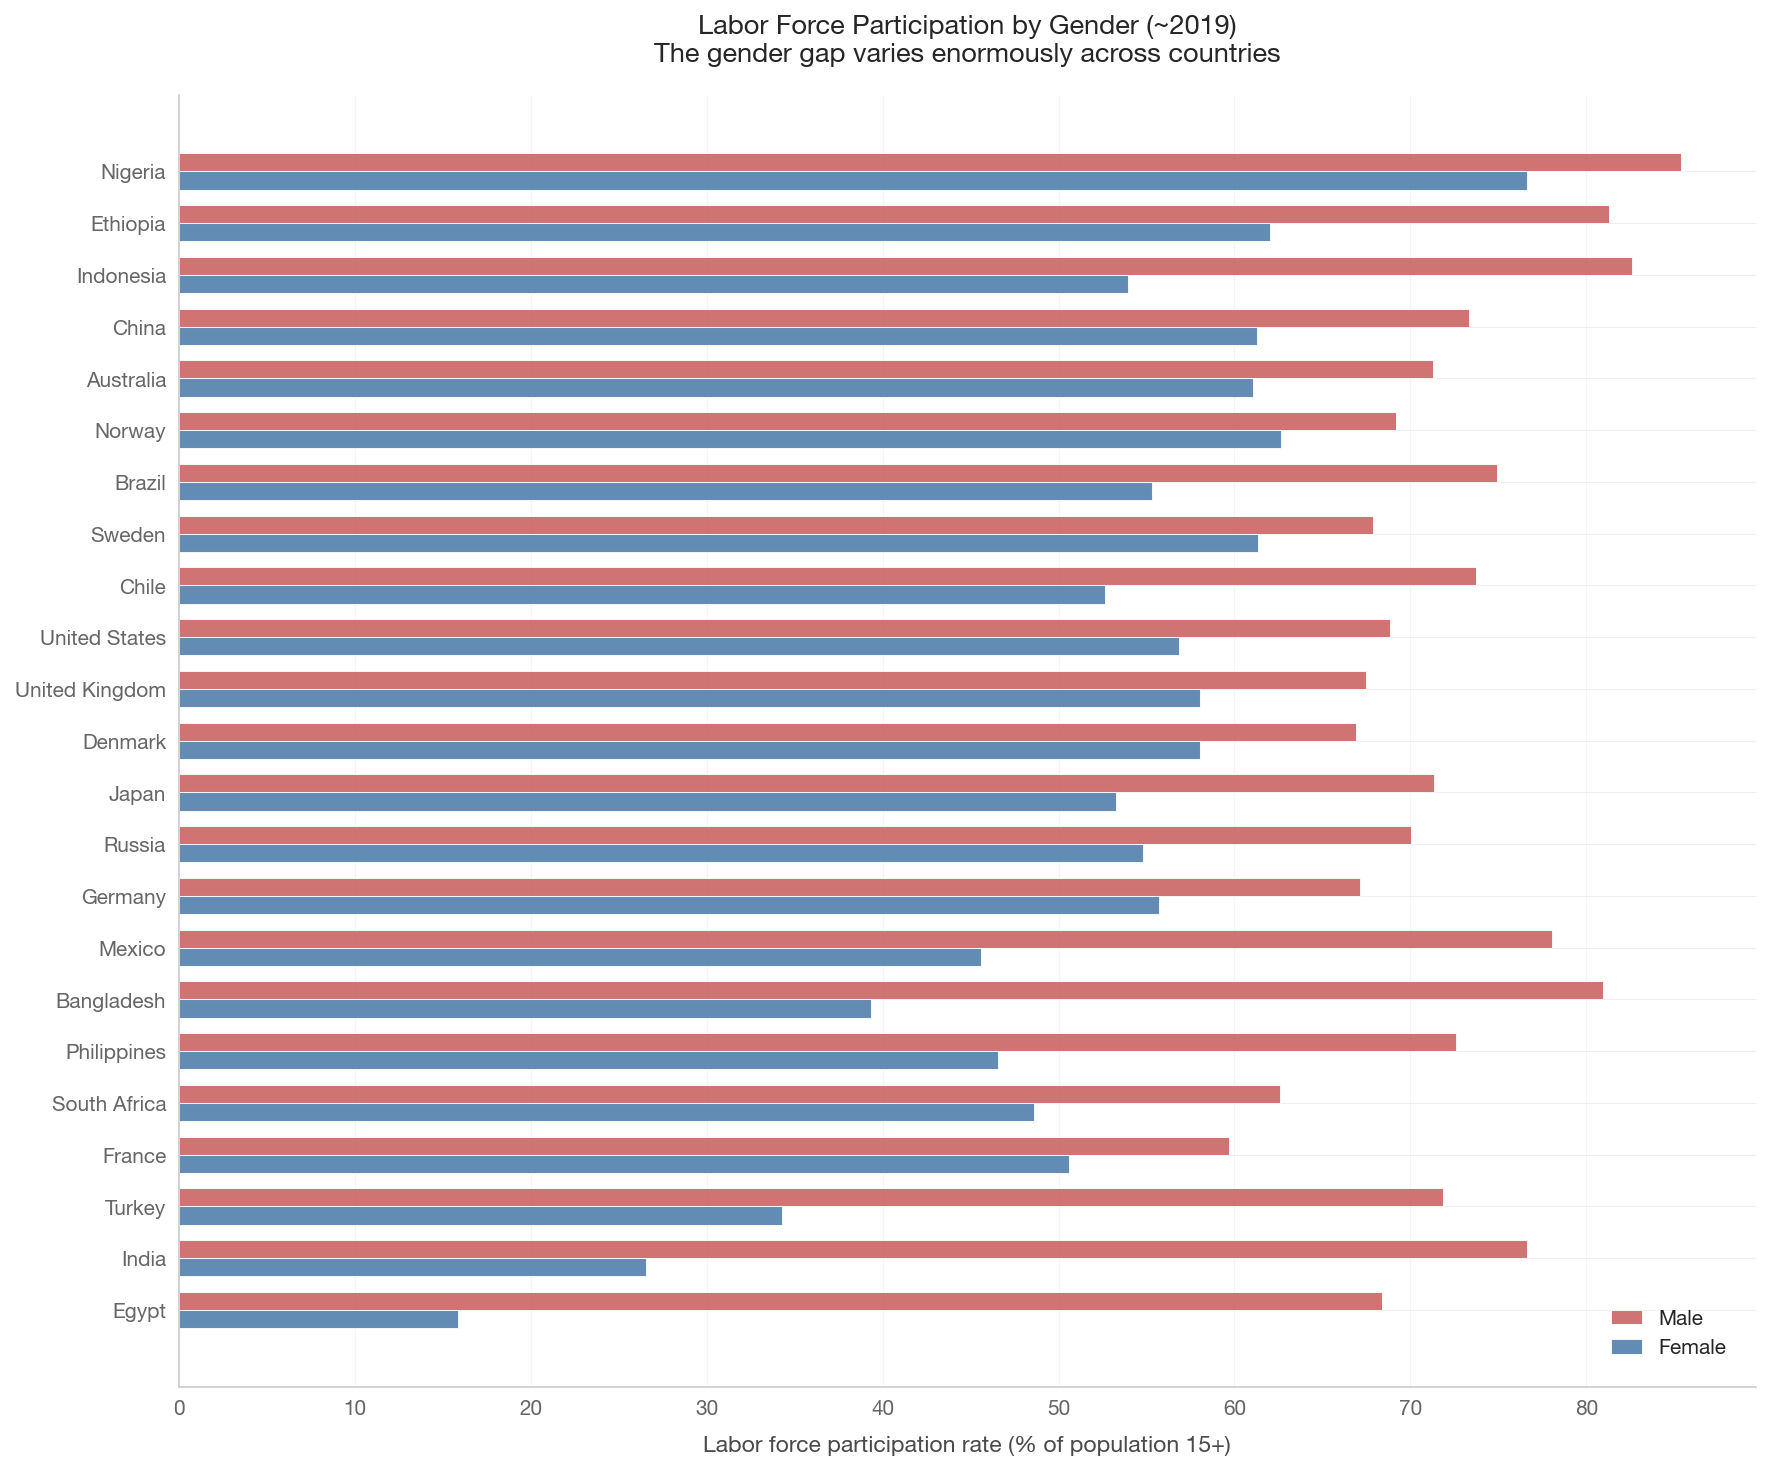

Largest gender gap: Egypt (52.5 pp)
Smallest gender gap: Sweden (6.5 pp)
Highest female LFP: Nigeria (76.6%)
Lowest female LFP: Egypt (15.9%)


In [6]:
lfp_snap = labor.get_labor_force_participation_snapshot(
    countries=WELLBEING_COUNTRIES, year=2019)

if not lfp_snap.empty and 'lfp_male' in lfp_snap.columns:
    # Sort by total LFP
    lfp_snap = lfp_snap.sort_values('lfp_total', ascending=True)
    countries_ordered = lfp_snap['country_code'].values
    y_pos = np.arange(len(lfp_snap))
    bar_height = 0.35

    fig, ax = plt.subplots(figsize=(12, 10))

    ax.barh(y_pos + bar_height/2, lfp_snap['lfp_male'],
            height=bar_height, color='#c75b5b', alpha=0.85,
            label='Male', edgecolor='white', linewidth=0.5)
    ax.barh(y_pos - bar_height/2, lfp_snap['lfp_female'],
            height=bar_height, color='#4878a8', alpha=0.85,
            label='Female', edgecolor='white', linewidth=0.5)

    ax.set_yticks(y_pos)
    ax.set_yticklabels([country_name(c) for c in countries_ordered])
    ax.set_xlabel('Labor force participation rate (% of population 15+)')
    ax.set_title('Labor Force Participation by Gender (~2019)\n'
                 'The gender gap varies enormously across countries',
                 fontsize=13)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '09_lfp_bar_chart')
    plt.show()

    # Key statistics
    print(f'Largest gender gap: '
          f'{country_name(lfp_snap.loc[lfp_snap["gender_gap"].idxmax(), "country_code"])} '
          f'({lfp_snap["gender_gap"].max():.1f} pp)')
    print(f'Smallest gender gap: '
          f'{country_name(lfp_snap.loc[lfp_snap["gender_gap"].idxmin(), "country_code"])} '
          f'({lfp_snap["gender_gap"].min():.1f} pp)')
    print(f'Highest female LFP: '
          f'{country_name(lfp_snap.loc[lfp_snap["lfp_female"].idxmax(), "country_code"])} '
          f'({lfp_snap["lfp_female"].max():.1f}%)')
    print(f'Lowest female LFP: '
          f'{country_name(lfp_snap.loc[lfp_snap["lfp_female"].idxmin(), "country_code"])} '
          f'({lfp_snap["lfp_female"].min():.1f}%)')
else:
    print('LFP data not available.')

***
## 4. The Gender Gap Over Time

The gender gap in labor force participation has narrowed in most rich
countries since 1990, but the pace varies enormously. Nordic countries
achieved near-parity decades ago; other countries still have gaps of
20-40 percentage points.

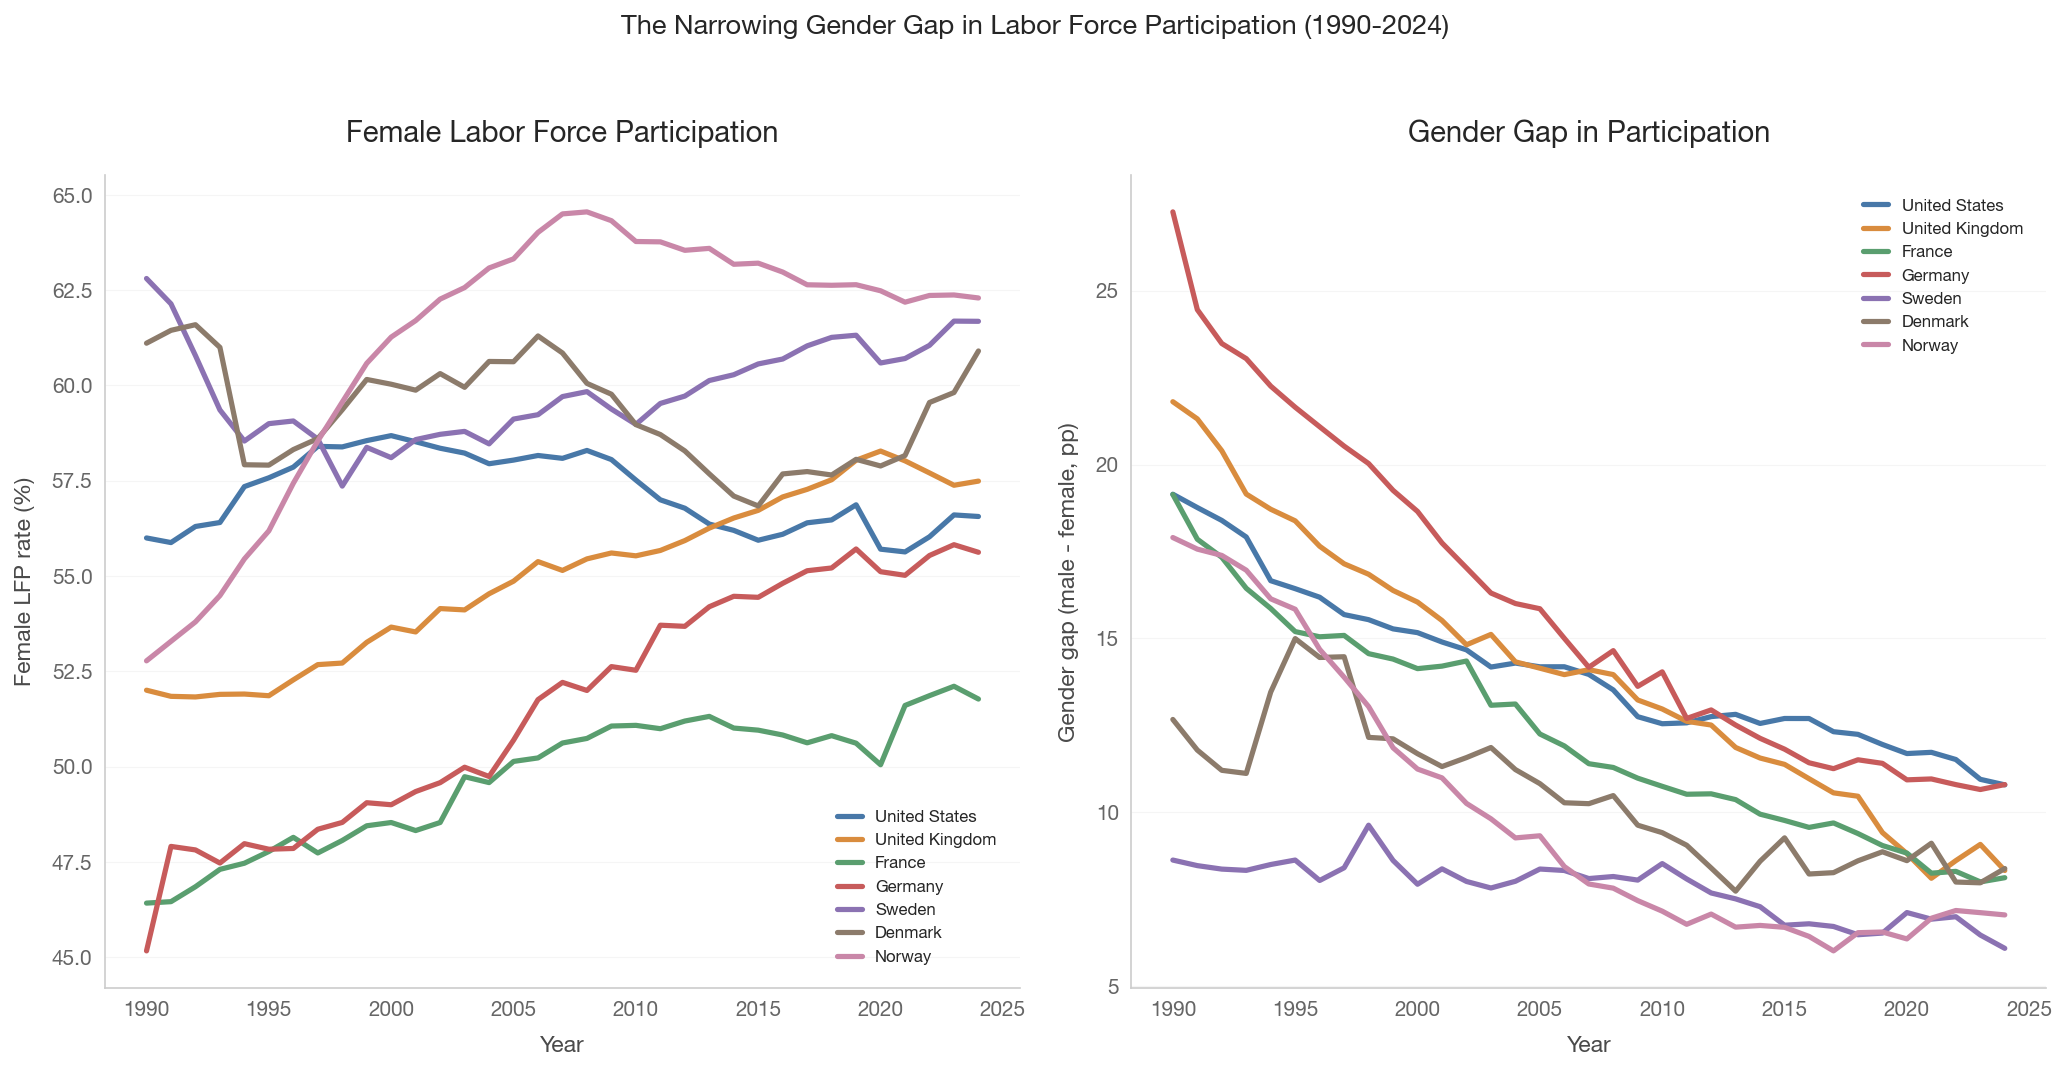

Gender gap (male - female LFP, pp): 1990 vs latest
  United States: 19.1 -> 10.8 (narrowed by 8.4 pp)
  United Kingdom: 21.8 -> 8.3 (narrowed by 13.5 pp)
  France: 19.1 -> 8.1 (narrowed by 11.0 pp)
  Germany: 27.3 -> 10.8 (narrowed by 16.5 pp)
  Sweden: 8.6 -> 6.1 (narrowed by 2.5 pp)
  Denmark: 12.7 -> 8.4 (narrowed by 4.3 pp)
  Norway: 17.9 -> 7.1 (narrowed by 10.8 pp)


In [7]:
# Load female and male LFP time series
lfp_female_ts = labor.get_labor_force_participation_timeseries(
    countries=FOCUS_COUNTRIES, start_year=1990, end_year=2024, gender='female')
lfp_male_ts = labor.get_labor_force_participation_timeseries(
    countries=FOCUS_COUNTRIES, start_year=1990, end_year=2024, gender='male')

if not lfp_female_ts.empty and not lfp_male_ts.empty:
    # Compute gender gap
    gap_ts = lfp_male_ts.merge(lfp_female_ts, on=['country_code', 'year'],
                                suffixes=('_male', '_female'))
    gap_ts['gender_gap'] = gap_ts['lfp_rate_male'] - gap_ts['lfp_rate_female']

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Left: Female LFP over time
    ax = axes[0]
    for cc in FOCUS_COUNTRIES:
        cdf = lfp_female_ts[lfp_female_ts['country_code'] == cc].sort_values('year')
        if not cdf.empty:
            ax.plot(cdf['year'], cdf['lfp_rate'],
                    color=country_color(cc), linewidth=2.5,
                    label=country_name(cc))
    ax.set_xlabel('Year')
    ax.set_ylabel('Female LFP rate (%)')
    ax.set_title('Female Labor Force Participation')
    ax.legend(loc='best', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

    # Right: Gender gap over time
    ax = axes[1]
    for cc in FOCUS_COUNTRIES:
        cdf = gap_ts[gap_ts['country_code'] == cc].sort_values('year')
        if not cdf.empty:
            ax.plot(cdf['year'], cdf['gender_gap'],
                    color=country_color(cc), linewidth=2.5,
                    label=country_name(cc))
    ax.set_xlabel('Year')
    ax.set_ylabel('Gender gap (male - female, pp)')
    ax.set_title('Gender Gap in Participation')
    ax.legend(loc='best', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

    fig.suptitle('The Narrowing Gender Gap in Labor Force Participation (1990-2024)',
                 fontsize=13, y=1.02)
    plt.tight_layout()
    save_figure(fig, '09_lfp_gender_gap_timeseries')
    plt.show()

    # Report gap change
    print('Gender gap (male - female LFP, pp): 1990 vs latest')
    for cc in FOCUS_COUNTRIES:
        cdf = gap_ts[gap_ts['country_code'] == cc].sort_values('year')
        if len(cdf) >= 2:
            g1 = cdf.iloc[0]['gender_gap']
            g2 = cdf.iloc[-1]['gender_gap']
            print(f'  {country_name(cc)}: {g1:.1f} -> {g2:.1f} '
                  f'(narrowed by {g1-g2:.1f} pp)')
else:
    print('LFP time series data not available.')

Correlation (Gini vs gender gap): r = 0.302, p = 0.1607


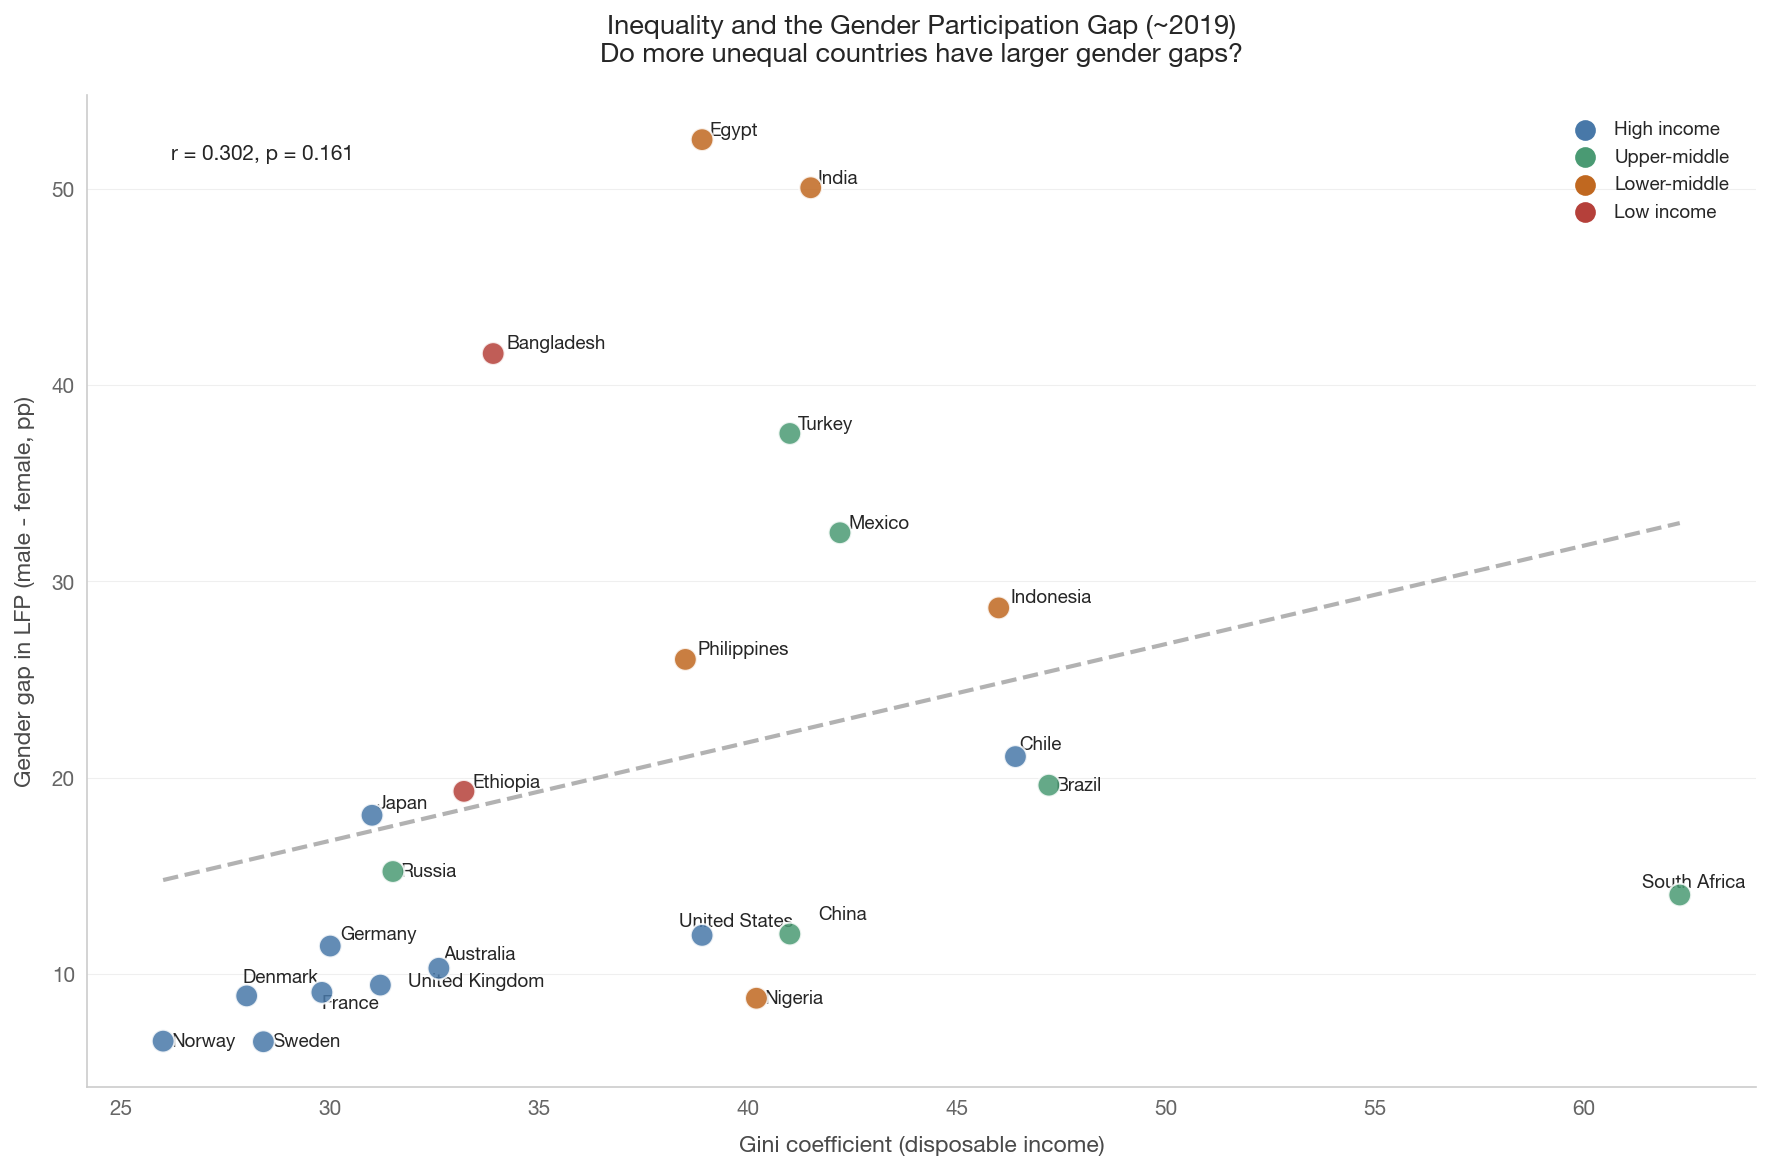

In [8]:
if not lfp_snap.empty and 'gender_gap' in lfp_snap.columns:
    wb_data = health_social.get_wellbeing_data(year=2019)
    if not wb_data.empty and 'gini_disp' in wb_data.columns:
        merged = lfp_snap.merge(
            wb_data[['country_code', 'gini_disp']],
            on='country_code', how='inner')
        merged = merged.dropna(subset=['gini_disp', 'gender_gap'])

        if len(merged) >= 5:
            fig, ax = plt.subplots(figsize=(12, 8))
            colors = [tier_color(c) for c in merged['country_code']]
            ax.scatter(merged['gini_disp'], merged['gender_gap'],
                       c=colors, s=120, zorder=5, edgecolors='white',
                       linewidth=1, alpha=0.85)

            x = merged['gini_disp'].values
            y = merged['gender_gap'].values
            mask = np.isfinite(x) & np.isfinite(y)
            if mask.sum() > 3:
                sl, it, r, p, se = stats.linregress(x[mask], y[mask])
                xf = np.linspace(x[mask].min(), x[mask].max(), 100)
                ax.plot(xf, it + sl * xf, color='gray', linestyle='--',
                        linewidth=2, alpha=0.6)
                ax.text(0.05, 0.95,
                        f'r = {r:.3f}, p = {p:.3f}',
                        transform=ax.transAxes, fontsize=10, va='top',
                        bbox=dict(boxstyle='round', facecolor='white',
                                  alpha=0.8))
                print(f'Correlation (Gini vs gender gap): r = {r:.3f}, p = {p:.4f}')

            annotate_countries(ax, merged['gini_disp'].values,
                               merged['gender_gap'].values,
                               merged['country_code'].values)

            ax.set_xlabel('Gini coefficient (disposable income)')
            ax.set_ylabel('Gender gap in LFP (male - female, pp)')
            ax.set_title('Inequality and the Gender Participation Gap (~2019)\n'
                         'Do more unequal countries have larger gender gaps?',
                         fontsize=13)

            for tier, color in TIER_COLORS.items():
                ax.scatter([], [], c=color, s=80, label=tier)
            ax.legend(loc='best', fontsize=9)

            plt.tight_layout()
            save_figure(fig, '09_lfp_gender_gap_vs_gini')
            plt.show()
        else:
            print(f'Only {len(merged)} countries with both Gini and LFP data.')
    else:
        print('Gini data not available.')
else:
    print('LFP snapshot not available for gender gap vs Gini.')

***
## 5. Working Hours and Productivity

A common assumption: more hours = more output. But the relationship
between hours and productivity (GDP per hour worked) is more complex.
Countries with shorter hours often achieve *higher* output per hour.
Pencavel (2015) found that beyond ~48 hours per week, additional
hours produce diminishing or even negative marginal returns.

The US works substantially more hours than Germany or France but does not
achieve proportionally more GDP per hour. The extra hours buy GDP per
capita, but at the cost of leisure.

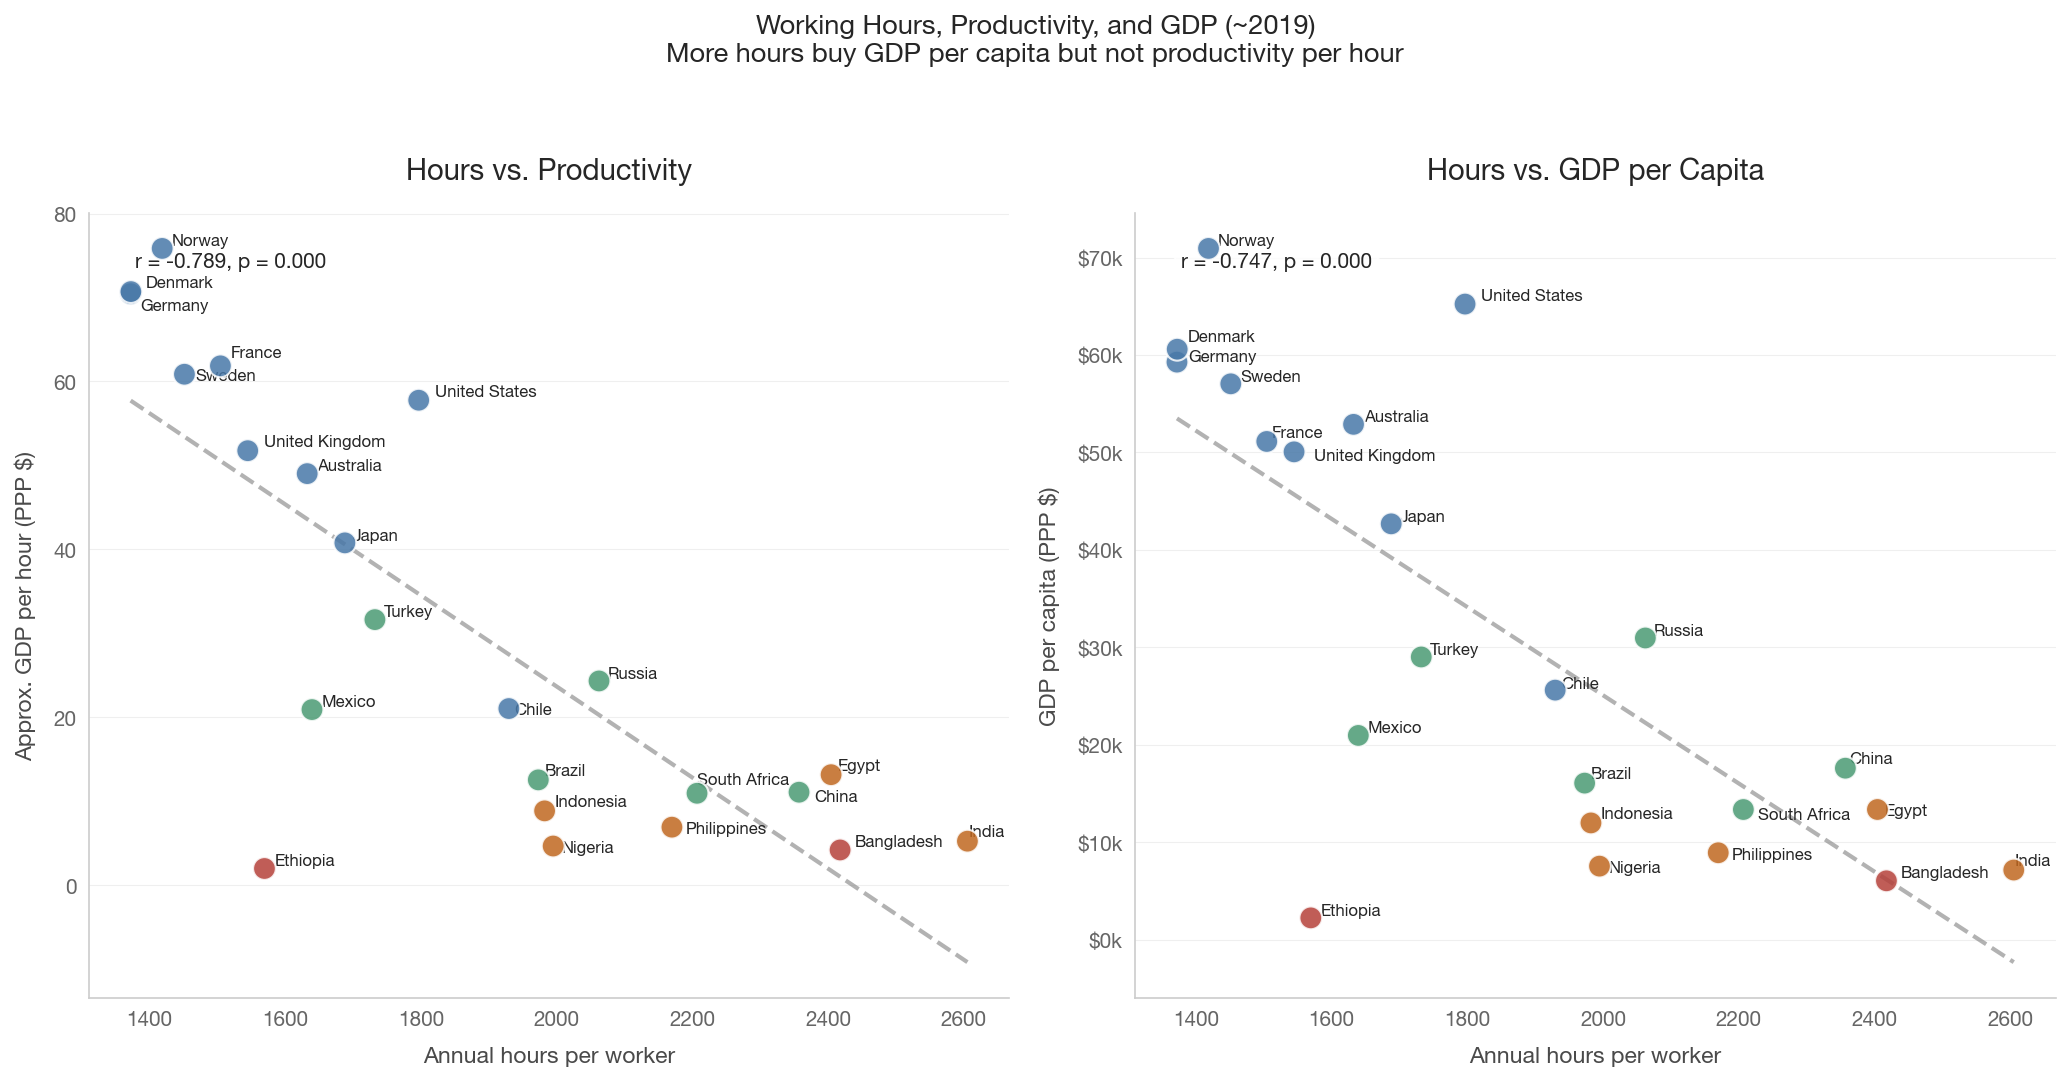

Approximate GDP per hour (top 5):
  Norway: $75.8/hr, 1419 hrs/yr
  Denmark: $70.7/hr, 1372 hrs/yr
  Germany: $70.5/hr, 1372 hrs/yr
  France: $61.9/hr, 1504 hrs/yr
  Sweden: $60.9/hr, 1451 hrs/yr

Correlation (hours vs GDP/hour): r = -0.789, p = 0.0000
Correlation (hours vs GDP/capita): r = -0.747, p = 0.0000


In [9]:
if not hours_snap.empty:
    wb_data = health_social.get_wellbeing_data(year=2019)
    lfp_data = labor.get_labor_force_participation_snapshot(
        countries=WELLBEING_COUNTRIES, year=2019)

    if not wb_data.empty and not lfp_data.empty:
        # Merge all three
        prod = (hours_snap
                .merge(wb_data[['country_code', 'gdp_per_capita_ppp']],
                       on='country_code', how='inner')
                .merge(lfp_data[['country_code', 'lfp_total']],
                       on='country_code', how='inner'))
        prod = prod.dropna()

        # Approximate GDP per hour
        prod['gdp_per_hour'] = (prod['gdp_per_capita_ppp']
                                 / (prod['lfp_total'] / 100
                                    * prod['hours_per_worker']))

        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Panel 1: Hours vs GDP per hour (productivity)
        ax = axes[0]
        colors = [tier_color(c) for c in prod['country_code']]
        ax.scatter(prod['hours_per_worker'], prod['gdp_per_hour'],
                   c=colors, s=120, zorder=5, edgecolors='white',
                   linewidth=1, alpha=0.85)

        x = prod['hours_per_worker'].values
        y = prod['gdp_per_hour'].values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() > 3:
            sl, it, r, p, _ = stats.linregress(x[mask], y[mask])
            xf = np.linspace(x[mask].min(), x[mask].max(), 100)
            ax.plot(xf, it + sl * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95, f'r = {r:.3f}, p = {p:.3f}',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        annotate_countries(ax, prod['hours_per_worker'].values,
                           prod['gdp_per_hour'].values,
                           prod['country_code'].values, fontsize=8)
        ax.set_xlabel('Annual hours per worker')
        ax.set_ylabel('Approx. GDP per hour (PPP $)')
        ax.set_title('Hours vs. Productivity')

        # Panel 2: Hours vs GDP per capita
        ax = axes[1]
        ax.scatter(prod['hours_per_worker'], prod['gdp_per_capita_ppp'],
                   c=colors, s=120, zorder=5, edgecolors='white',
                   linewidth=1, alpha=0.85)

        y2 = prod['gdp_per_capita_ppp'].values
        if mask.sum() > 3:
            sl2, it2, r2, p2, _ = stats.linregress(x[mask], y2[mask])
            xf = np.linspace(x[mask].min(), x[mask].max(), 100)
            ax.plot(xf, it2 + sl2 * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95, f'r = {r2:.3f}, p = {p2:.3f}',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        annotate_countries(ax, prod['hours_per_worker'].values,
                           prod['gdp_per_capita_ppp'].values,
                           prod['country_code'].values, fontsize=8)
        ax.set_xlabel('Annual hours per worker')
        ax.set_ylabel('GDP per capita (PPP $)')
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(
            lambda x, _: f'${x/1000:.0f}k'))
        ax.set_title('Hours vs. GDP per Capita')

        fig.suptitle('Working Hours, Productivity, and GDP (~2019)\n'
                     'More hours buy GDP per capita but not productivity per hour',
                     fontsize=13, y=1.03)
        plt.tight_layout()
        save_figure(fig, '09_hours_vs_productivity')
        plt.show()

        # Report top 5 by GDP per hour
        print('Approximate GDP per hour (top 5):')
        top = prod.nlargest(5, 'gdp_per_hour')
        for _, row in top.iterrows():
            print(f'  {country_name(row["country_code"])}: '
                  f'${row["gdp_per_hour"]:.1f}/hr, '
                  f'{row["hours_per_worker"]:.0f} hrs/yr')

        print(f'\nCorrelation (hours vs GDP/hour): r = {r:.3f}, p = {p:.4f}')
        print(f'Correlation (hours vs GDP/capita): r = {r2:.3f}, p = {p2:.4f}')
    else:
        print('GDP or LFP data not available.')
else:
    print('Working hours data not available.')

***
## 6. Working Hours and Well-being

Does working more make people happier? Notebook 07 showed that absolute
income is the strongest cross-sectional predictor of national happiness.
But if extra working hours are *how* some countries achieve higher GDP,
then the hours themselves may erode well-being through reduced leisure,
increased stress, and diminished social capital.

The critical test is whether working hours have an *independent* effect
on happiness after controlling for income — using the same residualization
technique from Notebook 07.

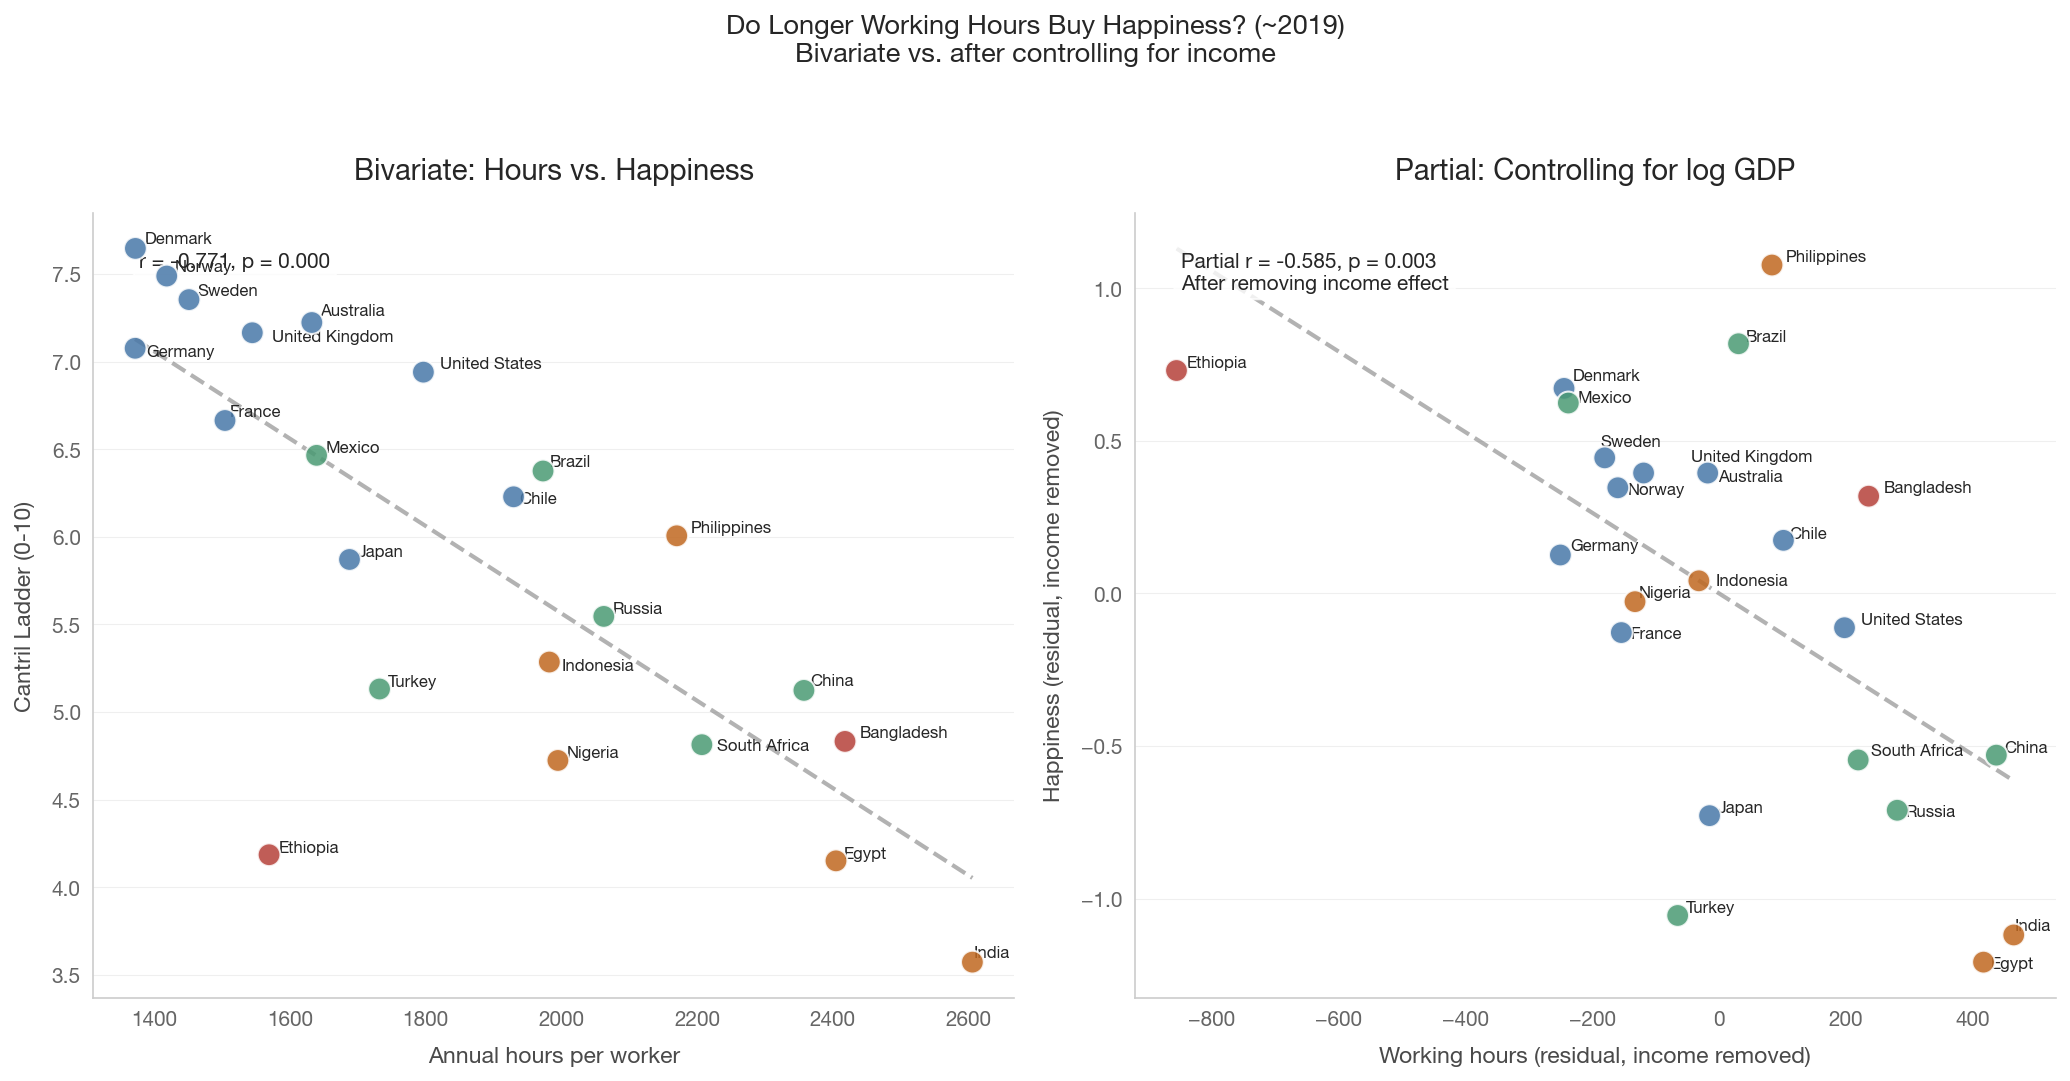

Bivariate: r = -0.771, p = 0.0000
Partial (controlling for log GDP): r = -0.585, p = 0.0034


In [10]:
if not hours_snap.empty:
    happiness = health_social.get_happiness_scores(year=2019)
    wb_data = health_social.get_wellbeing_data(year=2019)

    if not happiness.empty and not wb_data.empty:
        merged = (hours_snap
                  .merge(happiness, on='country_code', how='inner')
                  .merge(wb_data[['country_code', 'gdp_per_capita_ppp']],
                         on='country_code', how='inner'))
        merged = merged.dropna(subset=['happiness_score',
                                        'hours_per_worker',
                                        'gdp_per_capita_ppp'])

        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Panel 1: Bivariate
        ax = axes[0]
        colors = [tier_color(c) for c in merged['country_code']]
        ax.scatter(merged['hours_per_worker'], merged['happiness_score'],
                   c=colors, s=120, zorder=5, edgecolors='white',
                   linewidth=1, alpha=0.85)

        x_raw = merged['hours_per_worker'].values
        y_raw = merged['happiness_score'].values
        mask = np.isfinite(x_raw) & np.isfinite(y_raw)
        if mask.sum() > 3:
            sl, it, r, p, _ = stats.linregress(x_raw[mask], y_raw[mask])
            xf = np.linspace(x_raw[mask].min(), x_raw[mask].max(), 100)
            ax.plot(xf, it + sl * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95, f'r = {r:.3f}, p = {p:.3f}',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        annotate_countries(ax, x_raw, y_raw,
                           merged['country_code'].values, fontsize=8)
        ax.set_xlabel('Annual hours per worker')
        ax.set_ylabel('Cantril Ladder (0-10)')
        ax.set_title('Bivariate: Hours vs. Happiness')

        # Panel 2: Partial regression
        ax = axes[1]
        log_gdp = np.log(merged['gdp_per_capita_ppp'].values)
        full_mask = np.isfinite(x_raw) & np.isfinite(y_raw) & np.isfinite(log_gdp)

        if full_mask.sum() > 5:
            # Residualize hours on log GDP
            sl_xz, it_xz, _, _, _ = stats.linregress(
                log_gdp[full_mask], x_raw[full_mask])
            resid_hours = x_raw[full_mask] - (it_xz + sl_xz * log_gdp[full_mask])

            # Residualize happiness on log GDP
            sl_yz, it_yz, _, _, _ = stats.linregress(
                log_gdp[full_mask], y_raw[full_mask])
            resid_happy = y_raw[full_mask] - (it_yz + sl_yz * log_gdp[full_mask])

            colors_partial = [tier_color(c) for c in
                              merged['country_code'].values[full_mask]]
            ax.scatter(resid_hours, resid_happy,
                       c=colors_partial, s=120, zorder=5,
                       edgecolors='white', linewidth=1, alpha=0.85)

            sl_p, it_p, r_p, p_p, _ = stats.linregress(
                resid_hours, resid_happy)
            xf = np.linspace(resid_hours.min(), resid_hours.max(), 100)
            ax.plot(xf, it_p + sl_p * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95,
                    f'Partial r = {r_p:.3f}, p = {p_p:.3f}\n'
                    f'After removing income effect',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            annotate_countries(
                ax, resid_hours, resid_happy,
                merged['country_code'].values[full_mask], fontsize=8)

        ax.set_xlabel('Working hours (residual, income removed)')
        ax.set_ylabel('Happiness (residual, income removed)')
        ax.set_title('Partial: Controlling for log GDP')

        fig.suptitle('Do Longer Working Hours Buy Happiness? (~2019)\n'
                     'Bivariate vs. after controlling for income',
                     fontsize=13, y=1.03)
        plt.tight_layout()
        save_figure(fig, '09_hours_vs_happiness')
        plt.show()

        print(f'Bivariate: r = {r:.3f}, p = {p:.4f}')
        if full_mask.sum() > 5:
            print(f'Partial (controlling for log GDP): r = {r_p:.3f}, '
                  f'p = {p_p:.4f}')
    else:
        print('Happiness or GDP data not available.')
else:
    print('Working hours data not available.')

***
## 7. Working Hours and Inequality

Alesina, Glaeser & Sacerdote (2005) argued that Europeans work less
than Americans partly because of stronger labor market regulation
(unions, mandated vacation, maximum-hours laws). More redistributive
countries may also create less incentive to work long hours, because
marginal tax rates are higher and public services reduce the need to
earn.

Alternatively, higher inequality may *force* lower-income workers to
work longer hours to maintain their living standards. Either way, we
would expect a positive correlation between inequality and working hours.

Bivariate: Gini vs hours r = 0.560, p = 0.0055


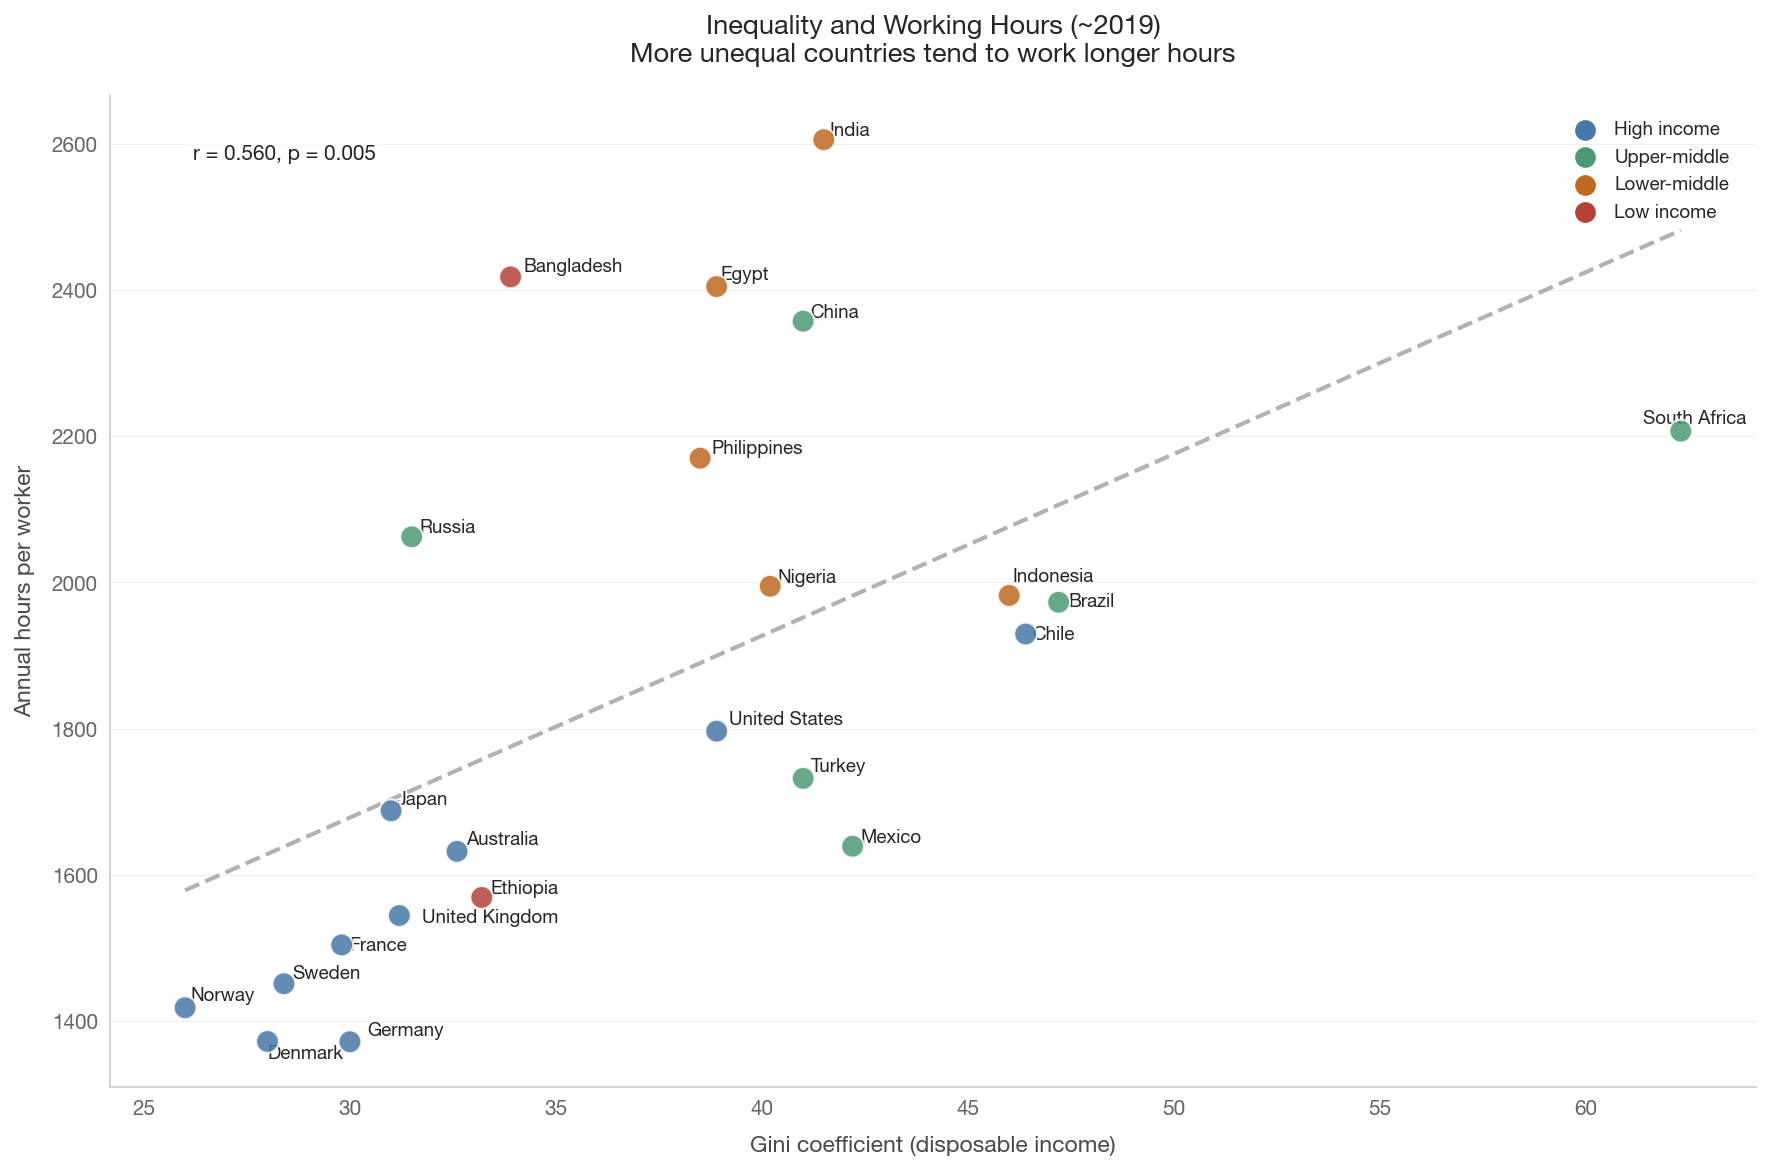

In [11]:
if not hours_snap.empty:
    wb_data = health_social.get_wellbeing_data(year=2019)

    if not wb_data.empty and 'gini_disp' in wb_data.columns:
        merged = hours_snap.merge(
            wb_data[['country_code', 'gini_disp', 'gdp_per_capita_ppp']],
            on='country_code', how='inner')
        merged = merged.dropna(subset=['gini_disp', 'hours_per_worker'])

        if len(merged) >= 5:
            fig, ax = plt.subplots(figsize=(12, 8))
            colors = [tier_color(c) for c in merged['country_code']]
            ax.scatter(merged['gini_disp'], merged['hours_per_worker'],
                       c=colors, s=120, zorder=5, edgecolors='white',
                       linewidth=1, alpha=0.85)

            x = merged['gini_disp'].values
            y = merged['hours_per_worker'].values
            mask = np.isfinite(x) & np.isfinite(y)
            if mask.sum() > 3:
                sl, it, r, p, _ = stats.linregress(x[mask], y[mask])
                xf = np.linspace(x[mask].min(), x[mask].max(), 100)
                ax.plot(xf, it + sl * xf, color='gray', linestyle='--',
                        linewidth=2, alpha=0.6)
                ax.text(0.05, 0.95, f'r = {r:.3f}, p = {p:.3f}',
                        transform=ax.transAxes, fontsize=10, va='top',
                        bbox=dict(boxstyle='round', facecolor='white',
                                  alpha=0.8))
                print(f'Bivariate: Gini vs hours r = {r:.3f}, p = {p:.4f}')

            annotate_countries(ax, merged['gini_disp'].values,
                               merged['hours_per_worker'].values,
                               merged['country_code'].values)

            ax.set_xlabel('Gini coefficient (disposable income)')
            ax.set_ylabel('Annual hours per worker')
            ax.set_title('Inequality and Working Hours (~2019)\n'
                         'More unequal countries tend to work longer hours',
                         fontsize=13)

            for tier, color in TIER_COLORS.items():
                ax.scatter([], [], c=color, s=80, label=tier)
            ax.legend(loc='best', fontsize=9)

            plt.tight_layout()
            save_figure(fig, '09_hours_vs_gini')
            plt.show()
    else:
        print('Gini data not available.')
else:
    print('Working hours data not available.')

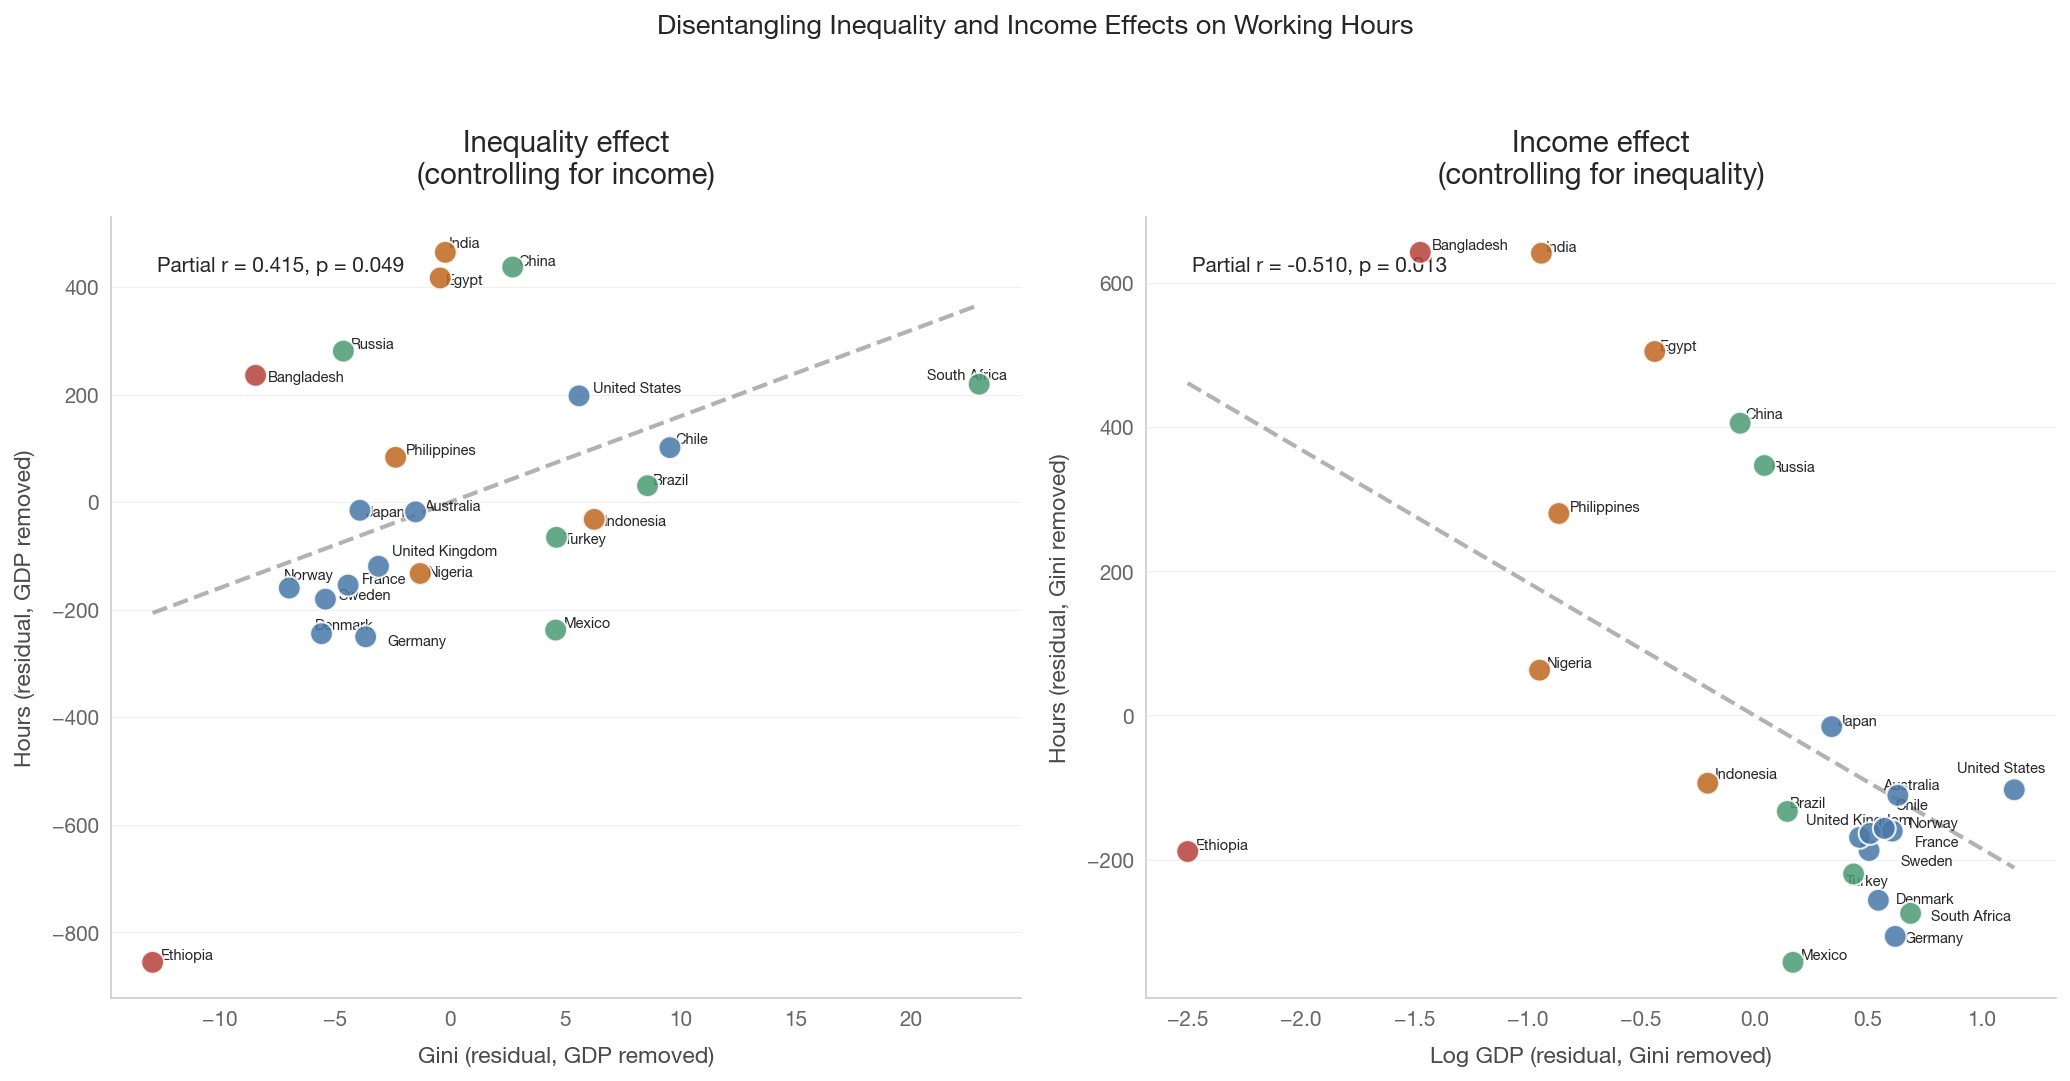

Partial r (hours vs Gini | GDP): 0.415, p = 0.0491
Partial r (hours vs GDP | Gini): -0.510, p = 0.0129


In [12]:
if not hours_snap.empty:
    wb_data = health_social.get_wellbeing_data(year=2019)
    if not wb_data.empty and 'gini_disp' in wb_data.columns:
        merged = hours_snap.merge(
            wb_data[['country_code', 'gini_disp', 'gdp_per_capita_ppp']],
            on='country_code', how='inner')
        merged = merged.dropna(subset=['gini_disp', 'hours_per_worker',
                                        'gdp_per_capita_ppp'])

        if len(merged) >= 8:
            hours = merged['hours_per_worker'].values
            gini = merged['gini_disp'].values
            log_gdp = np.log(merged['gdp_per_capita_ppp'].values)
            codes = merged['country_code'].values
            mask = np.isfinite(hours) & np.isfinite(gini) & np.isfinite(log_gdp)

            fig, axes = plt.subplots(1, 2, figsize=(14, 7))

            # Panel 1: Hours vs Gini, controlling for log GDP
            ax = axes[0]
            sl_xz, it_xz, _, _, _ = stats.linregress(log_gdp[mask], gini[mask])
            resid_gini = gini[mask] - (it_xz + sl_xz * log_gdp[mask])
            sl_yz, it_yz, _, _, _ = stats.linregress(log_gdp[mask], hours[mask])
            resid_hours_1 = hours[mask] - (it_yz + sl_yz * log_gdp[mask])

            colors = [tier_color(c) for c in codes[mask]]
            ax.scatter(resid_gini, resid_hours_1, c=colors, s=120, zorder=5,
                       edgecolors='white', linewidth=1, alpha=0.85)

            sl_p, it_p, r_p, p_p, _ = stats.linregress(resid_gini, resid_hours_1)
            xf = np.linspace(resid_gini.min(), resid_gini.max(), 100)
            ax.plot(xf, it_p + sl_p * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95, f'Partial r = {r_p:.3f}, p = {p_p:.3f}',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            annotate_countries(ax, resid_gini, resid_hours_1, codes[mask],
                               fontsize=7)
            ax.set_xlabel('Gini (residual, GDP removed)')
            ax.set_ylabel('Hours (residual, GDP removed)')
            ax.set_title('Inequality effect\n(controlling for income)')

            # Panel 2: Hours vs log GDP, controlling for Gini
            ax = axes[1]
            sl_xz2, it_xz2, _, _, _ = stats.linregress(gini[mask], log_gdp[mask])
            resid_lgdp = log_gdp[mask] - (it_xz2 + sl_xz2 * gini[mask])
            sl_yz2, it_yz2, _, _, _ = stats.linregress(gini[mask], hours[mask])
            resid_hours_2 = hours[mask] - (it_yz2 + sl_yz2 * gini[mask])

            ax.scatter(resid_lgdp, resid_hours_2, c=colors, s=120, zorder=5,
                       edgecolors='white', linewidth=1, alpha=0.85)

            sl_p2, it_p2, r_p2, p_p2, _ = stats.linregress(
                resid_lgdp, resid_hours_2)
            xf = np.linspace(resid_lgdp.min(), resid_lgdp.max(), 100)
            ax.plot(xf, it_p2 + sl_p2 * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95, f'Partial r = {r_p2:.3f}, p = {p_p2:.3f}',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            annotate_countries(ax, resid_lgdp, resid_hours_2, codes[mask],
                               fontsize=7)
            ax.set_xlabel('Log GDP (residual, Gini removed)')
            ax.set_ylabel('Hours (residual, Gini removed)')
            ax.set_title('Income effect\n(controlling for inequality)')

            fig.suptitle('Disentangling Inequality and Income Effects on Working Hours',
                         fontsize=13, y=1.03)
            plt.tight_layout()
            save_figure(fig, '09_hours_gini_gdp_multivariable')
            plt.show()

            print(f'Partial r (hours vs Gini | GDP): {r_p:.3f}, p = {p_p:.4f}')
            print(f'Partial r (hours vs GDP | Gini): {r_p2:.3f}, p = {p_p2:.4f}')
        else:
            print(f'Only {len(merged)} countries with all three variables.')
    else:
        print('Gini data not available.')
else:
    print('Working hours data not available.')

***
## 8. Key Takeaways

### The great hours decline

Working hours have fallen dramatically over 150 years. In 1870, workers in
industrialized countries averaged 2,500-3,000+ hours per year. By 2019,
the range was 1,300-1,800 in most rich countries. This is one of the
largest improvements in quality of life delivered by economic development —
yet it rarely features in discussions of inequality or progress.

### The US-Europe divergence

Until the 1970s-1980s, American and European working hours tracked together.
Then they diverged: European hours continued falling (driven by union
bargaining, mandated vacation, and shorter workweeks), while US hours
plateaued or even rose. Today, Americans work 200-400 more hours per year
than Northern Europeans — equivalent to 5-10 extra workweeks annually.

This divergence is not primarily about different preferences. Alesina,
Glaeser & Sacerdote (2005) argue it reflects different labor market
institutions and political choices. Prescott (2004) points to differences
in marginal tax rates.

### Hours, productivity, and the American trade-off

Countries with shorter working hours often achieve *higher* output per
hour. The US achieves high GDP per capita partly through longer hours, not
just higher productivity. This represents a specific societal choice:
Americans trade leisure for GDP.

### Connecting to the Easterlin Paradox

Notebook 08 found that countries which grew richer over time did not clearly
grow happier. This notebook adds a potential mechanism: if extra GDP growth
comes partly from extra working hours, the cost is less leisure without a
corresponding happiness payoff. The US is the canonical example — richer
than most European peers in GDP per capita, but not in GDP per hour, and
no happier.

### Working hours and inequality

More unequal countries tend to have longer working hours. This could
reflect:
- **Institutional channels**: Countries with weaker unions and less
  regulation have both higher inequality and longer hours.
- **Compulsion**: In unequal countries, lower-income workers may need
  to work longer to maintain living standards.
- **Tax incentives**: Lower marginal tax rates (associated with less
  redistribution) make additional hours of work more financially rewarding.

### Data limitations

- **Averages mask variation**: Economy-wide average hours per worker
  obscures the gap between full-time and part-time workers, formal and
  informal sectors, and different occupations.
- **Historical data is selective**: Pre-1950 data from Huberman & Minns
  measures full-time production workers in non-agricultural activities,
  not the full economy.
- **Informal work**: In developing countries, labor force participation
  rates undercount informal work — especially women's unpaid domestic
  labor. Cross-country comparisons must be interpreted cautiously.
- **Approximate productivity**: GDP per hour is approximated from GDP per
  capita, participation rates, and hours per worker. OECD provides more
  precise data for member countries.
- **Small N**: With ~20 countries, cross-sectional correlations have
  limited statistical power and can be driven by outliers.